<a href="https://colab.research.google.com/github/johnlocke333/xray_image_classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**


In [9]:
!pip install scikeras

  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [10]:
!pip install scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
from IPython import get_ipython
from IPython.display import display

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/My Drive/xray.zip" -d "/content/drive/My Drive/xray"

In [ ]:
# Directory path
train_data_dir = '/content/drive/MyDrive/xray/chest_xray/chest_xray/train'
test_data_dir = '/content/drive/MyDrive/xray/chest_xray/chest_xray/test'
valid_data_dir = '/content/drive/MyDrive/xray/chest_xray/chest_xray/val'


In [ ]:
def get_reshape_images(dir, bs):
# Get all the data in the directory data/validation (5216 images), and reshape them, color to grayscale because they are xray images
  generator = ImageDataGenerator().flow_from_directory(
          dir, target_size=(64, 64), batch_size=bs)

# Create the datasets
  images, labels = next(generator)
  return images, labels

In [8]:
train_images, train_labels = get_reshape_images(train_data_dir, 5216)

Found 5216 images belonging to 2 classes.


In [11]:
test_images, test_labels = get_reshape_images(test_data_dir, 624)

Found 624 images belonging to 2 classes.


In [12]:
valid_images, valid_labels = get_reshape_images(valid_data_dir, 16)

Found 16 images belonging to 2 classes.


In [13]:
 def reshape_input_image_label(images, m, labels):
  img_unrow = images.reshape(m, -1)
  labels_final = labels.T[[1]].T
  return img_unrow, labels_final

In [14]:
train_img_unrow, train_label_final = reshape_input_image_label(train_images, 5216, train_labels)

In [15]:
test_img_unrow, test_label_final = reshape_input_image_label(test_images, 624, test_labels)

In [16]:
valid_img_unrow, valid_label_final = reshape_input_image_label(valid_images, 16, valid_labels)

In [17]:
def standardize(img_unrow):
  img_final = img_unrow/255
  return img_final

In [18]:
train_img_final = standardize(train_img_unrow)

In [19]:
test_img_final= standardize(test_img_unrow)

In [20]:
valid_img_final = standardize(valid_img_unrow)

# **Model**

In [21]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
def build_baseline(optimizer='SGD', activation='relu',neurons=2):
  baseline_model = models.Sequential()
  baseline_model.add(layers.Dense(neurons, activation=activation, input_shape=(12288,)))
  baseline_model.add(layers.Dense(1, activation='sigmoid'))
  baseline_model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['recall'])
  return baseline_model


In [23]:
baseline_model = build_baseline()
baseline_model.fit(train_img_final,
                    train_label_final,
                    epochs=6,
                    batch_size=3,
                    validation_data=(test_img_final, test_label_final))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6117 - recall: 0.9958 - val_loss: 0.6911 - val_recall: 1.0000
Epoch 2/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5705 - recall: 1.0000 - val_loss: 0.6964 - val_recall: 1.0000
Epoch 3/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5616 - recall: 1.0000 - val_loss: 0.6881 - val_recall: 1.0000
Epoch 4/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5702 - recall: 1.0000 - val_loss: 0.6969 - val_recall: 1.0000
Epoch 5/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5690 - recall: 1.0000 - val_loss: 0.6965 - val_recall: 1.0000
Epoch 6/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5652 - recall: 1.0000 - val_loss: 0.6950 - val_recall: 1.0000


In [ ]:
tuning_model=KerasClassifier(build_fn=build_baseline)

In [ ]:
param_grid = {
    "model__neurons": [2,5,10],
    "model__optimizer": ['SGD', 'adam', 'RMSProp'],
    "model__activation" : ['relu', 'tanh', 'sigmoid'],
    "epochs": [6,8,10],
    "batch_size" : [6,10,20]
}

In [ ]:
gs=GridSearchCV(estimator=tuning_model, param_grid=param_grid, cv=3)
# now fit the dataset to the GridSearchCV object.
gs = gs.fit(test_img_final, test_label_final)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7027 - recall: 0.9066
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6721 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6681 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6633 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6595 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6664 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6823 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6459 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6017 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5415 - recall: 0.9665
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5113 - recall: 0.8993
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5260 - recall: 0.8455
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6854 - recall: 0.9595
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6793 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6712 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6676 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6502 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6917 - recall: 0.9595
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6841 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6842 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6773 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6635 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6637 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6993 - recall: 0.7415
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6839 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6769 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6741 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7009 - recall: 0.9362
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6867 - recall: 0.9857
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6805 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6792 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6687 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7840 - recall: 0.9455
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6876 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6731 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6735 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6723 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6987 - recall: 0.6719
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6728 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6796 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6665 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6904 - recall: 0.9596
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6850 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6823 - recall: 0.9929
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6701 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7535 - recall: 0.9079
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6612 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6683 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6590 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6671 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6836 - recall: 0.9589
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6825 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6743 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6724 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6711 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6893 - recall: 0.9095
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6774 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6593 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6573 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6661 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5725 - recall: 0.8067
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3602 - recall: 0.9007
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2791 - recall: 0.8972
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3094 - recall: 0.9125
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2955 - recall: 0.9054
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2714 - recall: 0.8831
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6914 - recall: 0.9527
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6865 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6776 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6628 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6975 - recall: 0.8631
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6868 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6812 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6754 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6821 - recall: 0.9857
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6664 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6915 - recall: 0.9577
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6880 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6806 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6767 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6716 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6723 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6920 - recall: 0.9564
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6849 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6832 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6752 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6756 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6667 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6978 - recall: 0.9471
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6857 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 0.9929
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6628 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6473 - recall: 0.9712
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5644 - recall: 0.9603
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5081 - recall: 0.9452
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4667 - recall: 0.9009
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4416 - recall: 0.8730
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3898 - recall: 0.9369
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6744 - recall: 0.9903
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6160 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5673 - recall: 0.9403
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5247 - recall: 0.9656
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4593 - recall: 0.9262
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4699 - recall: 0.9366
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7335 - recall: 0.9428
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6794 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6721 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6558 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6529 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6507 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7281 - recall: 0.8275
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6865 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6842 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6758 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6697 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7050 - recall: 0.7537
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6820 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6790 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6591 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6173 - recall: 0.7049
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4376 - recall: 0.9009
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3602 - recall: 0.9214
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3929 - recall: 0.8670
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2998 - recall: 0.9240
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3216 - recall: 0.8759
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7354 - recall: 0.9566
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6854 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6997 - recall: 0.9151
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6853 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6806 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6723 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8787 - recall: 0.6893
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4531 - recall: 0.8582
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4032 - recall: 0.8635
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3662 - recall: 0.8840
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3066 - recall: 0.9252
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3405 - recall: 0.8447
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7349 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7122 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6904 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6771 - recall: 0.9798
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6710 - recall: 0.9504
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6728 - recall: 0.8328
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6587 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6605 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6571 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6363 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6610 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7934 - recall: 0.9522
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6761 - recall: 0.9954
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6842 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6599 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6501 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6754 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0471 - recall: 0.0000e+00
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9666 - recall: 0.0054
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7765 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6913 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7243 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6624 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7074 - recall: 0.8553
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7553 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7240 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6856 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6918 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6469 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8106 - recall: 0.2846
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5256 - recall: 0.8838
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4639 - recall: 0.8780
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4678 - recall: 0.8678
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4637 - recall: 0.7843
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4351 - recall: 0.8726
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9887 - recall: 0.0983
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8293 - recall: 0.2473
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6354 - recall: 0.8493
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5274 - recall: 0.8381
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4808 - recall: 0.8837
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4531 - recall: 0.9056
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0286 - recall: 0.4069
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9214 - recall: 0.4620
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7063 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7224 - recall: 0.9885
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7956 - recall: 0.6326
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5779 - recall: 0.8021
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6615 - recall: 0.9564
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6489 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6464 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6779 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6611 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6663 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7364 - recall: 0.7677
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6659 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6710 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6581 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6602 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6764 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9084 - recall: 0.0485
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6934 - recall: 0.4069
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6611 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6627 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6676 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6478 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7300 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6453 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6400 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6398 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5836 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5477 - recall: 0.9462
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8871 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8322 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8238 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7881 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7369 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7069 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7559 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7538 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7441 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6752 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6670 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6557 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7383 - recall: 0.8781
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7053 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6919 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6849 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6696 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6734 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6506 - recall: 0.9835
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7109 - recall: 0.9929
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6482 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6664 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6831 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7995 - recall: 0.6620
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7117 - recall: 0.9876
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6416 - recall: 0.9641
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6338 - recall: 0.9718
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6320 - recall: 0.5765
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4743 - recall: 0.9193
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6823 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6870 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6503 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6643 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6738 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6407 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8806 - recall: 0.9579
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6610 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6719 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6134 - recall: 0.9856
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5198 - recall: 0.8913
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5004 - recall: 0.7117
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6972 - recall: 0.6859
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5764 - recall: 0.8532
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4950 - recall: 0.8552
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4458 - recall: 0.9105
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3962 - recall: 0.8920
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4052 - recall: 0.8219
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6806 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6194 - recall: 0.9775
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5136 - recall: 0.9241
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4240 - recall: 0.9114
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4213 - recall: 0.8542
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4410 - recall: 0.7897
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7422 - recall: 0.9800
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6830 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6914 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7752 - recall: 0.3721
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6925 - recall: 0.5855
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6733 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6585 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6700 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6473 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9851 - recall: 0.0000e+00
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5054 - recall: 0.0000e+00
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1820 - recall: 0.0000e+00
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9253 - recall: 0.0000e+00
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7142 - recall: 0.0201
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6836 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6700 - recall: 0.9578
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6517 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6515 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6622 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1066 - recall: 0.9009
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6833 - recall: 0.9944
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6488 - recall: 0.7764
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5026 - recall: 0.8771
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4759 - recall: 0.8593
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4617 - recall: 0.8950
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.7739 - recall: 0.4275
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6673 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6436 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5417 - recall: 0.9960
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4397 - recall: 0.9444
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4406 - recall: 0.9066
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6403 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5847 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5591 - recall: 0.9985
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5171 - recall: 0.9997
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5132 - recall: 0.9549
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4754 - recall: 0.9832
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6634 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5896 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5894 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5434 - recall: 0.9874
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5138 - recall: 0.9559
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4962 - recall: 0.9866
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7022 - recall: 0.7060
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6732 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6649 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6699 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6676 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6608 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6289 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6487 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6885 - recall: 0.9929
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6579 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6612 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6578 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6940 - recall: 0.8645
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6857 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6825 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6711 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6605 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6482 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6795 - recall: 0.9929
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6535 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6577 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6657 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6736 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6656 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6570 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6802 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6524 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6663 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6969 - recall: 0.6942
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6853 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6743 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6722 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6601 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6985 - recall: 0.7142
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6855 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6828 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6769 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6680 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6352 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5869 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5536 - recall: 0.9999
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5199 - recall: 0.9995
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4793 - recall: 0.9864
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4501 - recall: 0.9709
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7061 - recall: 0.6616
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6677 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6553 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6566 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6540 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6776 - recall: 0.8063
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6207 - recall: 0.9152
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5786 - recall: 0.9049
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5418 - recall: 0.9455
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5187 - recall: 0.9264
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5060 - recall: 0.8961
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6516 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6439 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6820 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6546 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6592 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6833 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6938 - recall: 0.8149
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6817 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6752 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6756 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6763 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6823 - recall: 1.0000
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5753 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5474 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5095 - recall: 0.9999
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5514 - recall: 0.8658
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4689 - recall: 0.9881
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6683 - recall: 0.9595
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6437 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6137 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5828 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5542 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5526 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6841 - recall: 0.9458
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6621 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6610 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6600 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6724 - recall: 0.9472
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5579 - recall: 0.8829
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4528 - recall: 0.9280
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4253 - recall: 0.8829
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4076 - recall: 0.9372
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4141 - recall: 0.8752
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6779 - recall: 0.9264
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5964 - recall: 0.9338
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5363 - recall: 0.9091
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4904 - recall: 0.9507
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4646 - recall: 0.9552
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4321 - recall: 0.9259
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6438 - recall: 0.9530
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6088 - recall: 0.9874
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5460 - recall: 0.9662
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5579 - recall: 0.9578
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5065 - recall: 0.9480
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4865 - recall: 0.9518
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6763 - recall: 0.9330
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6368 - recall: 0.8761
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6036 - recall: 0.9616
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5470 - recall: 0.9509
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4879 - recall: 0.9605
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4753 - recall: 0.9516
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7156 - recall: 0.9372
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6689 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6615 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6757 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6684 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6700 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7133 - recall: 0.1577
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6769 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6623 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6520 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6476 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6934 - recall: 0.9592
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6496 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6296 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6502 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6573 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6659 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6268 - recall: 0.9813
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5493 - recall: 0.9454
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5051 - recall: 0.9590
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4350 - recall: 0.9482
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4187 - recall: 0.9073
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3960 - recall: 0.9415
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6745 - recall: 0.8971
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5719 - recall: 0.9392
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5000 - recall: 0.9275
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5042 - recall: 0.9427
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4859 - recall: 0.8916
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4588 - recall: 0.9127
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6506 - recall: 0.9622
Epoch 2/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6463 - recall: 1.0000
Epoch 3/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6622 - recall: 1.0000
Epoch 4/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6332 - recall: 1.0000
Epoch 5/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6135 - recall: 1.0000
Epoch 6/6
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6030 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6885 - recall: 0.8820
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6756 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6777 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6776 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6675 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6755 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6755 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6690 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7686 - recall: 0.8085
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6806 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6702 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6593 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6649 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6580 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6645 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6595 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6687 - recall: 0.9411
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6143 - recall: 0.9986
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5448 - recall: 0.9767
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4943 - recall: 0.8821
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4731 - recall: 0.9140
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4456 - recall: 0.8785
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4022 - recall: 0.8413
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3704 - recall: 0.8854
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6954 - recall: 0.9590
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6845 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6804 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6787 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6741 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6917 - recall: 0.9600
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6852 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6819 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6668 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6697 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6566 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6856 - recall: 0.8025
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6859 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6834 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6823 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6758 - recall: 0.9929
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6715 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6730 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6907 - recall: 0.9574
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6864 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6850 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6788 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6792 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6654 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6731 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7081 - recall: 0.8807
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6834 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6753 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6714 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6706 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6598 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6930 - recall: 0.8859
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6829 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6697 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6777 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6728 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6665 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7014 - recall: 0.8993
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6698 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 - recall: 0.9857
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6658 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6585 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6484 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6607 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6965 - recall: 0.9225
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6787 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6659 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6712 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6471 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6732 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6646 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6879 - recall: 0.9610
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6729 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6659 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6596 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6602 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6564 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6620 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6593 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7065 - recall: 0.7381
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6876 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6655 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7272 - recall: 0.9441
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6840 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6799 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6749 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6670 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6786 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6682 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6697 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7273 - recall: 0.9562
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6859 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6786 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6716 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6599 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7014 - recall: 0.9601
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6837 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6783 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 0.9929
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6754 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6621 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6655 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7971 - recall: 0.4512
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6886 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6825 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6714 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6670 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6721 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7104 - recall: 0.9271
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6858 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6814 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6612 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6738 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7167 - recall: 0.9554
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6559 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6101 - recall: 0.9929
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5343 - recall: 0.9334
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4887 - recall: 0.9617
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4350 - recall: 0.8922
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4321 - recall: 0.8380
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4304 - recall: 0.8754
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7290 - recall: 0.6509
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6731 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6781 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6599 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6450 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6726 - recall: 0.8484
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6802 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6690 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6580 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5826 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5053 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4948 - recall: 0.9685
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4523 - recall: 0.9009
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6696 - recall: 0.8825
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6884 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6810 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6703 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6657 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6743 - recall: 0.9929
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6641 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7870 - recall: 0.8569
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6866 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6783 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6783 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6690 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6753 - recall: 0.9929
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6659 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6989 - recall: 0.9577
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6834 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6830 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6800 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6710 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6669 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6695 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6739 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7081 - recall: 0.9223
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6787 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6744 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6677 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6681 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 0.9857
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7672 - recall: 0.8956
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6894 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6670 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7116 - recall: 0.9054
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6741 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6741 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6720 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6735 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8061 - recall: 0.9423
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6416 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6673 - recall: 0.9929
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6837 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6703 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6472 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6427 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7312 - recall: 0.5310
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6642 - recall: 0.9947
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6728 - recall: 0.9547
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5972 - recall: 0.8804
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5992 - recall: 0.9319
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5202 - recall: 0.8078
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4946 - recall: 0.9124
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4893 - recall: 0.8661
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6900 - recall: 0.8708
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6813 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6675 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6565 - recall: 0.8107
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6226 - recall: 0.7596
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5095 - recall: 0.8731
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5874 - recall: 0.9523
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4674 - recall: 0.8042
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5932 - recall: 0.8624
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5743 - recall: 0.8511
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4464 - recall: 0.9123
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5083 - recall: 0.8806
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3680 - recall: 0.9039
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4818 - recall: 0.8057
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4018 - recall: 0.8968
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3682 - recall: 0.8864
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8592 - recall: 0.0297
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8402 - recall: 0.0000e+00
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7818 - recall: 0.0000e+00
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7417 - recall: 0.0000e+00
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7145 - recall: 0.0000e+00
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6981 - recall: 0.0915
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6864 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6756 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6719 - recall: 0.9475
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6689 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6639 - recall: 0.9929
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6625 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6547 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7622 - recall: 0.1162
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6380 - recall: 0.9127
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6061 - recall: 0.7867
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5670 - recall: 0.8743
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5191 - recall: 0.9042
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4900 - recall: 0.8684
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4822 - recall: 0.8627
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4576 - recall: 0.8640
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6819 - recall: 0.9398
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6667 - recall: 0.9929
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6794 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6543 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6674 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6624 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6682 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6637 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6794 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6550 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6871 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6776 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6642 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6596 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6379 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8428 - recall: 0.0067
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6800 - recall: 0.9792
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6858 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6565 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6535 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6531 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 - recall: 0.9929
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6635 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6532 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6271 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6106 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5488 - recall: 0.9827
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5119 - recall: 0.9389
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5193 - recall: 0.8442
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4634 - recall: 0.8164
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4819 - recall: 0.7942
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1544 - recall: 0.0845
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7451 - recall: 0.1068
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6735 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6642 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6724 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6786 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6648 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6579 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6998 - recall: 0.8783
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6748 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6720 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6641 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6450 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6666 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7161 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6621 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6655 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6543 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6518 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6532 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8857 - recall: 0.0275
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8329 - recall: 0.0000e+00
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7484 - recall: 0.0000e+00
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7146 - recall: 0.0000e+00
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6900 - recall: 0.7792
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6799 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6615 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6604 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7147 - recall: 0.9579
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7455 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6324 - recall: 0.9929
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5928 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5315 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5403 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4610 - recall: 0.9899
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9826 - recall: 0.0794
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6723 - recall: 0.6292
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5146 - recall: 0.8394
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5296 - recall: 0.8507
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5192 - recall: 0.7323
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4849 - recall: 0.8124
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4800 - recall: 0.8753
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4573 - recall: 0.8577
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7022 - recall: 0.9599
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6946 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6985 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6515 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6699 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6546 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6520 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6651 - recall: 0.9275
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5866 - recall: 0.9138
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5444 - recall: 0.8817
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4693 - recall: 0.9033
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4107 - recall: 0.8886
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3938 - recall: 0.8706
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3680 - recall: 0.8840
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3663 - recall: 0.8833
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7240 - recall: 0.4018
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5828 - recall: 0.9429
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4884 - recall: 0.9298
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4876 - recall: 0.8350
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4753 - recall: 0.8326
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4309 - recall: 0.8765
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4205 - recall: 0.8958
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4186 - recall: 0.9088
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8167 - recall: 0.5716
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6501 - recall: 0.9242
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5348 - recall: 0.8055
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4978 - recall: 0.8280
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4856 - recall: 0.8577
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4196 - recall: 0.8903
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4307 - recall: 0.8699
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3900 - recall: 0.8405
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6859 - recall: 0.9746
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6494 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6664 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6766 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6766 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6582 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6661 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6629 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1971 - recall: 0.0320
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8955 - recall: 0.0000e+00
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7624 - recall: 0.0000e+00
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6918 - recall: 0.4960
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6510 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6711 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8901 - recall: 0.9660
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8424 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6891 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6538 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6490 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6583 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6730 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0452 - recall: 0.2294
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6751 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6646 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6655 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6976 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7791 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5901 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5240 - recall: 0.9939
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7032 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7049 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6731 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6489 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6688 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7761 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7113 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7038 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6353 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6360 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5980 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5701 - recall: 0.9979
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5433 - recall: 0.8900
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7050 - recall: 0.4566
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6729 - recall: 0.9929
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6607 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6664 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6690 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6558 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6683 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6955 - recall: 0.3169
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6795 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6781 - recall: 0.9929
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6710 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6511 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6524 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6533 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6553 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6989 - recall: 0.4830
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6821 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6642 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6654 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6717 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6583 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6578 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5626 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5454 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5478 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5404 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5005 - recall: 0.9998
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4941 - recall: 0.9941
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4855 - recall: 0.9841
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6740 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6466 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6542 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6760 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6452 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6821 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6642 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6933 - recall: 0.8674
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6782 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6706 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6804 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6662 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6962 - recall: 0.9491
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6855 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6843 - recall: 0.9929
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6740 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6667 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6716 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6830 - recall: 0.8758
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6664 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6542 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6074 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5996 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5781 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5574 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6680 - recall: 0.9625
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5905 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5644 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5530 - recall: 0.9998
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5221 - recall: 0.9962
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5348 - recall: 0.9893
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5049 - recall: 0.9608
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5096 - recall: 0.9487
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6780 - recall: 0.9021
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6464 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5998 - recall: 0.9956
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5748 - recall: 0.9755
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5510 - recall: 0.9871
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5315 - recall: 0.9872
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4857 - recall: 0.9808
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4972 - recall: 0.9405
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7073 - recall: 0.4531
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6769 - recall: 0.9929
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6611 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6610 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6606 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6515 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6776 - recall: 0.8623
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5851 - recall: 0.7734
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5218 - recall: 0.8960
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4890 - recall: 0.9083
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4523 - recall: 0.9106
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4261 - recall: 0.9090
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3851 - recall: 0.9100
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3727 - recall: 0.9346
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6811 - recall: 0.9604
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6744 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6563 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6415 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6515 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6637 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6615 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5416 - recall: 0.9939
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5709 - recall: 0.9953
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5165 - recall: 0.9944
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4998 - recall: 0.9499
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4907 - recall: 0.9532
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4666 - recall: 0.9725
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4561 - recall: 0.9600
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6918 - recall: 0.8485
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6738 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6691 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6682 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6693 - recall: 0.9929
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6972 - recall: 0.8507
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6852 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6830 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6792 - recall: 0.9929
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6708 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6715 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6587 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6904 - recall: 0.9019
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5704 - recall: 0.9857
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4895 - recall: 0.9078
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4769 - recall: 0.8428
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4512 - recall: 0.8751
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4025 - recall: 0.9125
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4256 - recall: 0.8637
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3946 - recall: 0.8786
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6815 - recall: 0.7341
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6395 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6143 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6104 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5978 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5937 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5720 - recall: 0.9971
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5691 - recall: 0.9491
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6768 - recall: 0.8366
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6448 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6279 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6133 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5905 - recall: 0.9967
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5749 - recall: 0.9687
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5400 - recall: 0.9136
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5049 - recall: 0.9145
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6966 - recall: 0.7838
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6648 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6161 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6125 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5994 - recall: 0.9929
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5528 - recall: 0.9867
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6555 - recall: 1.0000
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6619 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6337 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6025 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5580 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5762 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5630 - recall: 0.9829
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5143 - recall: 0.9921
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7218 - recall: 0.7525
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6635 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6670 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6694 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6613 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6579 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6706 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7242 - recall: 0.7273
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6731 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6542 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6638 - recall: 1.0000
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6505 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6684 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6688 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6872 - recall: 0.7790
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6098 - recall: 0.9606
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5360 - recall: 0.9128
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4649 - recall: 0.9194
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4883 - recall: 0.8735
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4314 - recall: 0.9426
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4190 - recall: 0.9337
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4130 - recall: 0.8980
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7535 - recall: 0.5085
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5458 - recall: 0.8851
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4607 - recall: 0.8946
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4309 - recall: 0.8936
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3869 - recall: 0.8815
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3853 - recall: 0.8779
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3391 - recall: 0.9066
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3540 - recall: 0.8842
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6917 - recall: 0.9574
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6590 - recall: 1.0000
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6553 - recall: 1.0000
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6663 - recall: 1.0000
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6667 - recall: 0.9929
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6559 - recall: 1.0000
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6612 - recall: 1.0000
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6757 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6498 - recall: 0.9338
Epoch 2/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5693 - recall: 0.8643
Epoch 3/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5074 - recall: 0.8938
Epoch 4/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4556 - recall: 0.8544
Epoch 5/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4252 - recall: 0.9125
Epoch 6/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4143 - recall: 0.8705
Epoch 7/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4002 - recall: 0.9265
Epoch 8/8
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3707 - recall: 0.9055
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6934 - recall: 0.8881
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6685 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6756 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6555 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6479 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6537 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6482 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7011 - recall: 0.7882
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6842 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6686 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6712 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6706 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6588 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6355 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6588 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6557 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6901 - recall: 0.9222
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6781 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6552 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6618 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6534 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6620 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6745 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6503 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6488 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6918 - recall: 0.7791
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6849 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6708 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6687 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6606 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6558 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6922 - recall: 0.8458
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6800 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6751 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6723 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6721 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6675 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6760 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6716 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6913 - recall: 0.9577
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6854 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6750 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6685 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6663 - recall: 0.9929
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6705 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6670 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6527 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6906 - recall: 0.9498
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6746 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6674 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6637 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6566 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7169 - recall: 0.9555
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6850 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6802 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6741 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6820 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6772 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6694 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6678 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7392 - recall: 0.9644
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6427 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5377 - recall: 0.9959
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4766 - recall: 0.9008
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4807 - recall: 0.9124
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4190 - recall: 0.9211
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4281 - recall: 0.9186
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4297 - recall: 0.9066
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4298 - recall: 0.9028
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3725 - recall: 0.8866
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6878 - recall: 0.9616
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6744 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6690 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6551 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6693 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6669 - recall: 0.9929
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6677 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6535 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6503 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6618 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6993 - recall: 0.9662
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6620 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6557 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6764 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6691 - recall: 0.9929
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6648 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6387 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6633 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6647 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7129 - recall: 0.9443
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6685 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6606 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6703 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6365 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6456 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6618 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7976 - recall: 0.8150
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6878 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6839 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6759 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6775 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6742 - recall: 0.9929
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6668 - recall: 0.9929
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6554 - recall: 0.9929
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7153 - recall: 0.8784
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6855 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6741 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6731 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6655 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6687 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6665 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6736 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6576 - recall: 0.9441
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5790 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4845 - recall: 0.9948
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4679 - recall: 0.9740
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4689 - recall: 0.8643
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4253 - recall: 0.9501
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3943 - recall: 0.9697
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4046 - recall: 0.9427
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3728 - recall: 0.9460
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3497 - recall: 0.9345
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8342 - recall: 0.7808
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6868 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6732 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6807 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6689 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6743 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6652 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6922 - recall: 0.7433
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6849 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6823 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6801 - recall: 0.9929
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6661 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6665 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6528 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6912 - recall: 0.9413
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6868 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6842 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6726 - recall: 0.9929
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6740 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6638 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7377 - recall: 0.9145
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6564 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6711 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6440 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6534 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6597 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6906 - recall: 0.8641
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6694 - recall: 0.9628
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6452 - recall: 0.9027
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6157 - recall: 0.8443
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5614 - recall: 0.8414
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5190 - recall: 0.8311
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4885 - recall: 0.8717
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4511 - recall: 0.9318
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4700 - recall: 0.8924
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4414 - recall: 0.9074
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6917 - recall: 0.9256
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6707 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6693 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6699 - recall: 0.9929
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6722 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6535 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6751 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6644 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6643 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7280 - recall: 0.4734
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6812 - recall: 0.6308
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6227 - recall: 0.6516
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5799 - recall: 0.7877
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6570 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6688 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6655 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6547 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6663 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6938 - recall: 0.8005
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6862 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6847 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6788 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6803 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6712 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6595 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6754 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6748 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6387 - recall: 0.8615
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5357 - recall: 0.7946
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3632 - recall: 0.8764
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3025 - recall: 0.9256
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2825 - recall: 0.9048
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2334 - recall: 0.9360
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3319 - recall: 0.8595
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2450 - recall: 0.9144
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3059 - recall: 0.8915
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2605 - recall: 0.9044
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7083 - recall: 0.9343
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6835 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6785 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6751 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6732 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6650 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6726 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6696 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6690 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7054 - recall: 0.9175
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6838 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6775 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6780 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6687 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6553 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6654 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7122 - recall: 0.9572
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6865 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6786 - recall: 0.9929
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6732 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6813 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6756 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6695 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6622 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6703 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6958 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7063 - recall: 0.9003
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6865 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6486 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6769 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6512 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6486 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 0.9918
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6590 - recall: 0.9734
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6658 - recall: 0.9083
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8635 - recall: 0.1552
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6793 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6593 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6598 - recall: 0.9994
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6622 - recall: 0.7620
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5956 - recall: 0.8278
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5784 - recall: 0.7405
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5243 - recall: 0.8129
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4926 - recall: 0.8271
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4609 - recall: 0.8872
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7971 - recall: 0.9659
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7087 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6685 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6624 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6761 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6641 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6568 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6611 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6576 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6800 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6740 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6717 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6659 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6529 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6661 - recall: 0.9929
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6557 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6656 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6623 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6641 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6973 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6935 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6351 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6580 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6680 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6925 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6561 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6663 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7363 - recall: 0.9026
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7357 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7571 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6961 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7049 - recall: 0.9929
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6678 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6696 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6783 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6730 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6523 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6811 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7048 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6738 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7168 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6423 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6399 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 0.9929
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6600 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6677 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6607 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6710 - recall: 0.9826
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780 - recall: 0.9929
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6629 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6461 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6743 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6319 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6524 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6566 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6851 - recall: 0.9929
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6563 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6627 - recall: 0.8937
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8118 - recall: 0.1136
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6974 - recall: 0.6172
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5398 - recall: 0.8674
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5282 - recall: 0.8277
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4860 - recall: 0.9199
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4753 - recall: 0.8182
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4603 - recall: 0.8981
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4401 - recall: 0.8495
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4169 - recall: 0.8919
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6694 - recall: 0.9617
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5891 - recall: 0.9932
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5059 - recall: 0.8968
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5067 - recall: 0.8424
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4860 - recall: 0.8208
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4485 - recall: 0.8115
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4254 - recall: 0.8631
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4414 - recall: 0.8738
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4051 - recall: 0.8614
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4025 - recall: 0.9144
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6823 - recall: 0.9642
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6380 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5898 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5429 - recall: 0.9887
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5382 - recall: 0.8282
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4856 - recall: 0.9016
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5193 - recall: 0.8109
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5562 - recall: 0.7257
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4400 - recall: 0.8733
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4410 - recall: 0.8483
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6932 - recall: 0.9590
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6777 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6572 - recall: 0.9929
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6481 - recall: 0.9959
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5732 - recall: 0.9064
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5238 - recall: 0.8269
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5450 - recall: 0.8276
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4542 - recall: 0.8870
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4412 - recall: 0.8546
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4026 - recall: 0.9002
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6738 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6684 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6623 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6743 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6709 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6647 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6593 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6642 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6452 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6906 - recall: 0.9575
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6697 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6604 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6441 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7977 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8654 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7300 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7359 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6878 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7486 - recall: 0.9410
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6645 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6668 - recall: 0.9929
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6581 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6698 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6623 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6603 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6662 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7888 - recall: 0.9516
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6564 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5836 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5759 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5408 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4879 - recall: 0.9679
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4934 - recall: 0.9134
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4993 - recall: 0.8866
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4511 - recall: 0.8226
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8069 - recall: 0.2407
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 - recall: 0.9755
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6568 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6628 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6635 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6688 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6648 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6691 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7349 - recall: 0.7846
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7374 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7713 - recall: 0.9868
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7154 - recall: 0.9668
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6027 - recall: 0.8371
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5006 - recall: 0.8393
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4867 - recall: 0.8513
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4972 - recall: 0.8796
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4613 - recall: 0.9212
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4600 - recall: 0.8894
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6994 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6149 - recall: 0.9977
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5284 - recall: 0.9245
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4553 - recall: 0.9129
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4244 - recall: 0.8395
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3757 - recall: 0.8424
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4189 - recall: 0.8790
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3521 - recall: 0.8928
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3556 - recall: 0.8966
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3254 - recall: 0.9029
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7002 - recall: 0.6922
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6244 - recall: 0.8848
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6052 - recall: 0.8177
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4994 - recall: 0.8615
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4619 - recall: 0.9404
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4292 - recall: 0.8993
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4334 - recall: 0.9104
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4449 - recall: 0.9121
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5430 - recall: 0.6713
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3748 - recall: 0.8758
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6954 - recall: 0.9581
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6491 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5853 - recall: 0.9739
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5847 - recall: 0.7611
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5206 - recall: 0.8738
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5184 - recall: 0.8216
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4812 - recall: 0.8789
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5022 - recall: 0.8502
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4292 - recall: 0.8062
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4143 - recall: 0.8943
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6959 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6605 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6635 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6711 - recall: 0.9929
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6680 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6699 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6505 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6709 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6359 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6523 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7177 - recall: 0.9589
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6740 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6720 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6748 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6579 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6676 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6573 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6546 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6584 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8494 - recall: 0.9811
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8086 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7238 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6599 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6511 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6590 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6775 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6629 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6651 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1053 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7715 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7556 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7385 - recall: 0.9849
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5945 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5468 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5287 - recall: 0.9803
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4798 - recall: 0.9323
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4418 - recall: 0.9069
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4441 - recall: 0.8352
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9487 - recall: 0.9799
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7519 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6971 - recall: 0.9929
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5764 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5107 - recall: 0.9777
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5338 - recall: 0.7647
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4891 - recall: 0.8447
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5086 - recall: 0.7427
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4648 - recall: 0.8332
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2158 - recall: 0.3007
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7505 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6087 - recall: 0.9843
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5818 - recall: 0.7428
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4841 - recall: 0.9572
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4448 - recall: 0.8928
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4630 - recall: 0.7808
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3888 - recall: 0.8983
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3878 - recall: 0.9105
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3859 - recall: 0.9150
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7001 - recall: 0.3969
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6821 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6763 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6404 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6405 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6823 - recall: 0.9929
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 - recall: 0.9929
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6496 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6676 - recall: 0.9929
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6703 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6653 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6454 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6603 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6755 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6668 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6568 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6611 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6515 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6794 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6330 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6335 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5906 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5883 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5806 - recall: 0.9929
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5883 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5600 - recall: 0.9857
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5398 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5118 - recall: 0.9929
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6434 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5058 - recall: 0.9991
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5127 - recall: 0.9966
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4734 - recall: 0.9763
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4685 - recall: 0.9558
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4349 - recall: 0.9806
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4905 - recall: 0.8178
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4007 - recall: 0.9647
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4195 - recall: 0.9117
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4046 - recall: 0.9416
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6997 - recall: 0.8501
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6860 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6822 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6727 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6735 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6663 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6613 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6915 - recall: 0.9000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6858 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6794 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6810 - recall: 0.9929
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6722 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6772 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6742 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6643 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6669 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6669 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6716 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6627 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6562 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6692 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6524 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6476 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6706 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6714 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7104 - recall: 0.8064
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6863 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6820 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6804 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6704 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6688 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6720 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6723 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7148 - recall: 0.7591
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6863 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6746 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6782 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6707 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6661 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6572 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6690 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6533 - recall: 0.9425
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6127 - recall: 0.9818
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5815 - recall: 0.8959
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5252 - recall: 0.9645
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4833 - recall: 0.9539
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4394 - recall: 0.9451
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4216 - recall: 0.9561
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4402 - recall: 0.9122
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3980 - recall: 0.9027
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4098 - recall: 0.8899
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6619 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6319 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5995 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5650 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5454 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5543 - recall: 0.9856
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5511 - recall: 0.9938
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4888 - recall: 0.9900
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5165 - recall: 0.9847
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4724 - recall: 0.9675
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6275 - recall: 0.9957
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6049 - recall: 0.9970
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5711 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5295 - recall: 0.9973
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5209 - recall: 0.9438
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5250 - recall: 0.9757
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4689 - recall: 0.9813
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4558 - recall: 0.9485
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4725 - recall: 0.9216
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4503 - recall: 0.9438
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6929 - recall: 0.8505
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6603 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6665 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6674 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6597 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6764 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6581 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6728 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6523 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6665 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6259 - recall: 0.8328
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4878 - recall: 0.9170
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4429 - recall: 0.9174
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3792 - recall: 0.9453
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3734 - recall: 0.9348
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3598 - recall: 0.9145
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3512 - recall: 0.9420
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3876 - recall: 0.8588
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3523 - recall: 0.8830
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3915 - recall: 0.8845
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7679 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7126 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6379 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7258 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7043 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6927 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6870 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6628 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6668 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6947 - recall: 0.7709
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6852 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6814 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6702 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785 - recall: 0.9929
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6611 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6741 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6588 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6726 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6802 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6735 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6291 - recall: 0.9871
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5733 - recall: 0.9861
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5344 - recall: 0.9810
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5263 - recall: 0.9234
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5328 - recall: 0.9638
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4965 - recall: 0.9513
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4820 - recall: 0.9410
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4584 - recall: 0.9805
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7442 - recall: 0.5571
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6285 - recall: 0.8477
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5452 - recall: 0.9038
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5298 - recall: 0.8830
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5022 - recall: 0.9321
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5073 - recall: 0.8623
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4972 - recall: 0.9095
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4766 - recall: 0.8985
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4621 - recall: 0.9337
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4613 - recall: 0.8959
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6614 - recall: 0.9651
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6241 - recall: 0.9889
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5708 - recall: 0.9633
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5333 - recall: 0.9019
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4640 - recall: 0.9467
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4443 - recall: 0.9305
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4323 - recall: 0.9147
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4375 - recall: 0.9191
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3890 - recall: 0.9145
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3980 - recall: 0.8798
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6683 - recall: 0.7301
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5511 - recall: 0.9271
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4911 - recall: 0.9539
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4797 - recall: 0.9135
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4455 - recall: 0.9116
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4284 - recall: 0.9126
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3935 - recall: 0.9097
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3870 - recall: 0.9455
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3930 - recall: 0.8862
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4159 - recall: 0.8992
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6507 - recall: 0.8548
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5917 - recall: 0.9612
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5448 - recall: 0.9517
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4838 - recall: 0.9444
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4540 - recall: 0.8679
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4177 - recall: 0.9312
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4047 - recall: 0.9229
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4007 - recall: 0.8995
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3549 - recall: 0.9142
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3672 - recall: 0.8671
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7429 - recall: 0.8375
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6626 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6833 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6809 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6738 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6728 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6299 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6649 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6662 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6753 - recall: 1.0000
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6441 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6732 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6498 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6546 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6612 - recall: 1.0000
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6557 - recall: 1.0000
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6724 - recall: 1.0000
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6676 - recall: 1.0000
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6706 - recall: 1.0000
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6792 - recall: 0.8733
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6463 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5842 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5590 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5617 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5479 - recall: 0.9992
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5216 - recall: 0.9745
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4986 - recall: 0.9227
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4925 - recall: 0.9559
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4998 - recall: 0.9600
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6903 - recall: 0.8555
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5926 - recall: 0.9064
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4849 - recall: 0.8486
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4096 - recall: 0.8884
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4016 - recall: 0.8711
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3841 - recall: 0.8932
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3794 - recall: 0.8249
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3563 - recall: 0.8841
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3648 - recall: 0.9188
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2911 - recall: 0.9240
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7022 - recall: 0.6485
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5273 - recall: 0.9745
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5182 - recall: 0.9174
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4897 - recall: 0.8733
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4336 - recall: 0.8464
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4355 - recall: 0.8888
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3925 - recall: 0.8705
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4104 - recall: 0.8845
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3556 - recall: 0.9269
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3349 - recall: 0.8852
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6627 - recall: 0.9215
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6740 - recall: 1.0000
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6506 - recall: 1.0000
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6578 - recall: 1.0000
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6424 - recall: 1.0000
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6657 - recall: 0.9301
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6108 - recall: 0.9095
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5778 - recall: 0.8513
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5546 - recall: 0.9139
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5378 - recall: 0.9176
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7159 - recall: 0.9308
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6804 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6763 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6662 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6581 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6902 - recall: 0.8835
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6801 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6736 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6661 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6726 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6605 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7057 - recall: 0.9274
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6822 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6777 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6689 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6544 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6919 - recall: 0.9463
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6872 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6842 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6807 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6741 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6751 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6797 - recall: 0.9678
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6901 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6864 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6795 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6781 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6920 - recall: 0.8610
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6841 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6787 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6818 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7011 - recall: 0.8682
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6866 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6838 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6832 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6810 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7741 - recall: 0.6853
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6878 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6855 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6840 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6928 - recall: 0.9234
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6854 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6841 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6824 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6758 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6703 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6960 - recall: 0.9255
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6714 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6810 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6715 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7607 - recall: 0.8900
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6790 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6820 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6735 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6788 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6583 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6451 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6113 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5711 - recall: 0.9978
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5119 - recall: 0.9823
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5116 - recall: 0.9417
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6961 - recall: 0.9157
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6877 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6813 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6781 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6787 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6752 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7421 - recall: 0.7466
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6890 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6819 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6788 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7552 - recall: 0.8301
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6831 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6819 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6800 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6760 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7132 - recall: 0.9276
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6859 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6775 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6753 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6898 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6867 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6840 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6799 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6809 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6738 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7018 - recall: 0.8152
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6887 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6851 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6789 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6775 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7000 - recall: 0.8657
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7220 - recall: 0.7420
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6847 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6665 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6674 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6669 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6986 - recall: 0.8930
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6461 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5945 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5676 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5085 - recall: 0.9733
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4812 - recall: 0.9246
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6975 - recall: 0.8573
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6897 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6871 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6805 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6779 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6735 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6926 - recall: 0.6895
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6890 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6848 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6816 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6789 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6753 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5932 - recall: 0.8305
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4101 - recall: 0.8911
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3956 - recall: 0.9291
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3120 - recall: 0.9076
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3133 - recall: 0.9204
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2456 - recall: 0.9324
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8362 - recall: 0.6015
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6890 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6861 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7146 - recall: 0.8766
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6893 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6805 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6766 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7186 - recall: 0.6950
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6860 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6848 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6703 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8127 - recall: 0.9198
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7188 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6844 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7153 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7119 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6674 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6786 - recall: 0.9735
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6963 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6592 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6761 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6731 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7472 - recall: 0.9643
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7250 - recall: 0.9510
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6864 - recall: 0.9994
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8429 - recall: 0.4807
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5906 - recall: 0.8812
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5239 - recall: 0.8925
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6795 - recall: 0.9370
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6740 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6742 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6675 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6601 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7878 - recall: 0.9251
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7606 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7383 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7126 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6741 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7149 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7004 - recall: 0.0832
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6891 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6829 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6684 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6777 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6601 - recall: 0.9329
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6639 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6514 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6372 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6703 - recall: 0.9283
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6593 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6459 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6469 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6345 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6631 - recall: 0.9451
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6595 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6801 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6543 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7139 - recall: 0.7075
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6212 - recall: 0.7997
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5765 - recall: 0.7801
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5039 - recall: 0.9035
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5174 - recall: 0.8503
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4343 - recall: 0.8935
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7126 - recall: 0.9196
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6426 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6505 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6419 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5950 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5530 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6928 - recall: 0.6813
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6214 - recall: 0.9381
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5845 - recall: 0.8667
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4914 - recall: 0.9132
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4986 - recall: 0.8148
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4341 - recall: 0.9437
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7904 - recall: 0.9296
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7802 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7631 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7018 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6873 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7137 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7733 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8225 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7922 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8018 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7658 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7181 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6979 - recall: 0.5690
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5181 - recall: 0.9223
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5016 - recall: 0.8850
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4701 - recall: 0.9040
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4487 - recall: 0.9356
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4183 - recall: 0.9397
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9077 - recall: 0.5600
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6589 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6928 - recall: 0.9766
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6769 - recall: 0.9900
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6770 - recall: 0.7566
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5264 - recall: 0.7474
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8143 - recall: 0.9151
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7780 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6723 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7091 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6518 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6270 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6864 - recall: 0.8975
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6321 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6197 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6165 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6061 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5787 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6729 - recall: 0.7524
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6061 - recall: 0.8552
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5566 - recall: 0.9084
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4712 - recall: 0.9019
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4195 - recall: 0.9003
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4056 - recall: 0.8496
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9011 - recall: 4.3379e-04
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6827 - recall: 0.9737
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6627 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6745 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6544 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6459 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6553 - recall: 0.8351
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5937 - recall: 0.8855
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5597 - recall: 0.9782
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4795 - recall: 0.8521
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4629 - recall: 0.8502
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3903 - recall: 0.9268
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8074 - recall: 0.7017
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6503 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6723 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6528 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6863 - recall: 0.9544
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6665 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6770 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6728 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6650 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6634 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9488 - recall: 0.9098
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8094 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7587 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7307 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6690 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6881 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1911 - recall: 0.9389
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7542 - recall: 0.9924
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6819 - recall: 0.3322
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5915 - recall: 0.8613
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4954 - recall: 0.8662
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4654 - recall: 0.8455
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2108 - recall: 0.1130
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6931 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6997 - recall: 0.9887
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6429 - recall: 0.9333
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5020 - recall: 0.8945
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4675 - recall: 0.8543
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7578 - recall: 0.4298
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7764 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6121 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5584 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5190 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6366 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6276 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5936 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5938 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5328 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5410 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7347 - recall: 0.4131
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6633 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6678 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6974 - recall: 0.2899
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6849 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6688 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6707 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6651 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6711 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6920 - recall: 0.5972
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6938 - recall: 0.7618
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6855 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6841 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6794 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6769 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6950 - recall: 0.4271
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6879 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6787 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6763 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6831 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7030 - recall: 0.9182
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6885 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6861 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6840 - recall: 0.9859
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6795 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6790 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6357 - recall: 0.9985
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6205 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5841 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5801 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5471 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5345 - recall: 0.9986
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6995 - recall: 0.6324
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6890 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6736 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6758 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6774 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6942 - recall: 0.8943
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6851 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6844 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6826 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6767 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6802 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6727 - recall: 0.9823
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6319 - recall: 0.9903
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6071 - recall: 0.9930
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5857 - recall: 0.9654
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5438 - recall: 0.9737
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5303 - recall: 0.9845
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7297 - recall: 0.2354
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6843 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6708 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6673 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6638 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6429 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6828 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6527 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6898 - recall: 0.8726
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6814 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6740 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6561 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6571 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6657 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6787 - recall: 0.9824
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5789 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5596 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5376 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5283 - recall: 0.9924
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5117 - recall: 0.9830
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7144 - recall: 0.6219
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6895 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6771 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6857 - recall: 0.8299
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6418 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6268 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6053 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6045 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6846 - recall: 0.9947
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5837 - recall: 0.9997
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5393 - recall: 0.9926
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5406 - recall: 0.9817
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4863 - recall: 0.9801
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4888 - recall: 0.9684
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6963 - recall: 0.7578
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6845 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6799 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6811 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6721 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6733 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6250 - recall: 0.9758
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5853 - recall: 0.9802
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5443 - recall: 0.9719
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5219 - recall: 0.9624
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4984 - recall: 0.9468
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6532 - recall: 0.9899
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6117 - recall: 0.9712
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5848 - recall: 0.9309
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5460 - recall: 0.9665
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5291 - recall: 0.9667
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4895 - recall: 0.9806
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7073 - recall: 0.9216
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5992 - recall: 0.9960
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5280 - recall: 0.9921
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4727 - recall: 0.9793
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4687 - recall: 0.9276
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4478 - recall: 0.9536
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6900 - recall: 1.0000
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6810 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6226 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6002 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5981 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5980 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7230 - recall: 0.3757
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6391 - recall: 0.9393
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6762 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6127 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5593 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7131 - recall: 0.9159
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6843 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6586 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6453 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6740 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6651 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6557 - recall: 0.9390
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6444 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6143 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5918 - recall: 0.9920
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5491 - recall: 0.9748
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5442 - recall: 0.9091
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6848 - recall: 0.6464
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5741 - recall: 0.9224
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4916 - recall: 0.9339
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5333 - recall: 0.7888
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4620 - recall: 0.9010
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4183 - recall: 0.9178
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6825 - recall: 0.9417
Epoch 2/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
Epoch 3/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6687 - recall: 1.0000
Epoch 4/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6558 - recall: 1.0000
Epoch 5/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6622 - recall: 1.0000
Epoch 6/6
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6662 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6908 - recall: 0.8696
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6800 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6720 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6611 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6616 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6668 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6626 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6905 - recall: 0.9201
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6839 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6747 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6810 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6788 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6629 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6586 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7003 - recall: 0.8355
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6748 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6734 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6649 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6675 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6955 - recall: 0.9405
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6878 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6834 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6668 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6934 - recall: 0.8240
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6895 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6853 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6835 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6780 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6720 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6689 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7109 - recall: 0.7466
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6885 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6798 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6715 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6767 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6662 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8967 - recall: 0.9177
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6877 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6835 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6747 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6873 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7049 - recall: 0.9157
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6867 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6855 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6911 - recall: 0.9212
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6876 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6764 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6798 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6729 - recall: 0.9859
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6612 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6908 - recall: 0.8794
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6822 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6773 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6607 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6565 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6510 - recall: 0.9845
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6204 - recall: 0.9578
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5911 - recall: 0.9230
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7029 - recall: 0.9293
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6740 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6608 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6548 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6585 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6902 - recall: 0.8977
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6868 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6769 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6714 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6677 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6746 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7058 - recall: 0.7588
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6781 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6758 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6743 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7010 - recall: 0.7166
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6803 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6813 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6820 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6738 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6738 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6749 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6926 - recall: 0.5061
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6854 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6748 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6824 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8602 - recall: 0.8558
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6898 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6738 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7166 - recall: 0.8576
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7071 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6984 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6849 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6709 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7292 - recall: 0.9144
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5443 - recall: 0.9568
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5000 - recall: 0.8821
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4552 - recall: 0.8877
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4158 - recall: 0.9154
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4438 - recall: 0.9457
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4042 - recall: 0.9094
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4018 - recall: 0.8669
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6748 - recall: 0.8864
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6869 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6795 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6694 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6743 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6754 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6769 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7014 - recall: 0.6952
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6819 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6690 - recall: 0.9993
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6556 - recall: 0.9849
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6472 - recall: 0.9766
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6229 - recall: 0.9266
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5860 - recall: 0.9225
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5495 - recall: 0.8509
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6976 - recall: 0.9267
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6834 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6756 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6728 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6630 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6666 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6934 - recall: 0.6253
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6837 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6809 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6747 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6681 - recall: 0.8616
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5588 - recall: 0.9502
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4951 - recall: 0.9737
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4463 - recall: 0.9718
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4412 - recall: 0.9811
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4286 - recall: 0.9761
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4288 - recall: 0.9495
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4165 - recall: 0.9700
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6946 - recall: 0.7606
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6874 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6841 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6805 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6772 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6752 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6734 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6643 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7670 - recall: 0.9606
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6833 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6861 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6805 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6758 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6711 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6765 - recall: 0.9297
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6216 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5861 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5197 - recall: 0.9994
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5148 - recall: 0.9890
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4797 - recall: 0.9701
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4294 - recall: 0.9894
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4475 - recall: 0.9496
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2334 - recall: 0.6524
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5775 - recall: 0.8347
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4569 - recall: 0.8331
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4110 - recall: 0.8457
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3461 - recall: 0.9040
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5693 - recall: 0.8371
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3104 - recall: 0.9001
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3887 - recall: 0.8617
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6677 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6598 - recall: 0.9938
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6105 - recall: 0.8987
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5906 - recall: 0.8561
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5427 - recall: 0.9044
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5221 - recall: 0.9059
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5036 - recall: 0.9006
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4441 - recall: 0.9093
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6714 - recall: 0.8306
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6570 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6530 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6688 - recall: 0.9977
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6309 - recall: 0.9204
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5954 - recall: 0.8915
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5575 - recall: 0.9060
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5510 - recall: 0.8833
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6719 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6579 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6485 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6793 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6506 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6434 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6597 - recall: 0.8376
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7085 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6432 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6496 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6472 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6334 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6794 - recall: 0.8823
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6631 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6735 - recall: 0.9551
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6721 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6646 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6677 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6588 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6640 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6848 - recall: 0.9570
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6670 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6680 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6460 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6371 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6484 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6808 - recall: 0.9028
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6534 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6677 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6578 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6722 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6555 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6717 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6591 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6818 - recall: 0.9448
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7965 - recall: 0.6943
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7029 - recall: 0.8656
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5630 - recall: 0.8755
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5722 - recall: 0.7906
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5410 - recall: 0.8360
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4687 - recall: 0.8757
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4882 - recall: 0.9387
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6894 - recall: 0.9106
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6749 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6529 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6494 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6658 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6423 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6746 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6616 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6969 - recall: 0.9294
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6541 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6163 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5773 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5152 - recall: 0.9277
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5027 - recall: 0.9156
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4942 - recall: 0.8245
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4644 - recall: 0.8622
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7012 - recall: 0.8797
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 - recall: 0.8803
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6758 - recall: 0.9274
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6430 - recall: 0.9906
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5771 - recall: 0.9776
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5737 - recall: 0.9386
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4852 - recall: 0.8260
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4539 - recall: 0.9015
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6824 - recall: 0.8922
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6161 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5721 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5319 - recall: 0.9637
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5019 - recall: 0.9775
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4612 - recall: 0.9013
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4636 - recall: 0.9130
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4915 - recall: 0.8341
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7176 - recall: 0.9263
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6392 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6590 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6585 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6547 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6666 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6635 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6192 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7823 - recall: 0.9302
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7175 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7511 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7141 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7123 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6371 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6747 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6896 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7231 - recall: 0.9577
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6921 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7106 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6947 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6337 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6497 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6697 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6946 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6673 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6463 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6682 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8054 - recall: 0.9338
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7207 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6332 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5333 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6090 - recall: 0.9899
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5446 - recall: 0.9416
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4620 - recall: 0.9167
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4703 - recall: 0.8612
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6624 - recall: 0.9239
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6906 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6519 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6730 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6607 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6855 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6841 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7193 - recall: 0.9017
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6386 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 - recall: 0.9745
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5874 - recall: 0.8220
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4534 - recall: 0.8371
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4549 - recall: 0.8493
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3888 - recall: 0.8522
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4466 - recall: 0.8987
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6947 - recall: 0.9154
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6113 - recall: 0.9950
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5385 - recall: 0.9447
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5187 - recall: 0.8250
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4593 - recall: 0.8917
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4402 - recall: 0.8787
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3708 - recall: 0.8930
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4223 - recall: 0.8867
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7107 - recall: 0.8350
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6280 - recall: 0.9987
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5726 - recall: 0.9388
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5347 - recall: 0.8721
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4883 - recall: 0.8806
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4538 - recall: 0.8706
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4048 - recall: 0.9024
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4233 - recall: 0.8823
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7914 - recall: 0.9176
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7069 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6631 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6773 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6676 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6746 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6605 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6794 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8783 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6685 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6658 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6527 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6940 - recall: 0.9859
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6573 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8131 - recall: 0.9474
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7960 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7490 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6965 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7004 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6447 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6399 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0161 - recall: 0.9412
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7719 - recall: 0.9552
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6642 - recall: 0.9593
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4862 - recall: 0.8572
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4627 - recall: 0.9061
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3695 - recall: 0.9350
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4299 - recall: 0.9084
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4639 - recall: 0.8841
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0081 - recall: 0.9287
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7045 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6947 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6648 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5817 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5175 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5102 - recall: 0.9456
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4667 - recall: 0.8761
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2416 - recall: 0.9187
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8313 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7581 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7527 - recall: 0.9863
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6649 - recall: 0.9904
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5971 - recall: 0.7701
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4941 - recall: 0.8469
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4916 - recall: 0.8886
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7055 - recall: 0.1562
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6812 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6666 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6617 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6577 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7193 - recall: 0.3813
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6803 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6721 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6584 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6666 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6699 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6661 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6307 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5861 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5471 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5178 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5136 - recall: 0.9979
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5305 - recall: 0.9982
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5221 - recall: 0.9947
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6997 - recall: 0.9937
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5641 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5424 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5314 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5198 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4993 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4801 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6979 - recall: 0.7644
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6872 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6794 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6754 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6670 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6963 - recall: 0.8792
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6882 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6843 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6849 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6677 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6665 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6557 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6596 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6883 - recall: 0.9451
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6013 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5442 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5259 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5242 - recall: 0.9937
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5153 - recall: 0.9884
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5136 - recall: 0.9897
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4924 - recall: 0.9981
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7077 - recall: 0.8235
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6884 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6879 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6747 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6953 - recall: 0.8947
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6863 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6863 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6776 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6861 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6725 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6785 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6690 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7326 - recall: 0.2407
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6872 - recall: 0.9970
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6701 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6776 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6827 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6629 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6502 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6871 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7043 - recall: 0.1608
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6847 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6674 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6517 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6574 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6678 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6758 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6498 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6487 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6455 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6476 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6296 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7102 - recall: 0.3928
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6872 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6845 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6822 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6819 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6770 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6705 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6753 - recall: 0.8218
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5725 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5576 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5209 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5131 - recall: 0.9996
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5078 - recall: 0.9741
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4916 - recall: 0.9969
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4859 - recall: 0.9920
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6834 - recall: 0.9174
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6710 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6753 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6821 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6457 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6971 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6758 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6678 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6851 - recall: 0.9204
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6785 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6588 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6599 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6674 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6601 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6635 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6705 - recall: 0.9812
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6678 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6632 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6635 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6738 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6763 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6606 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6496 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5734 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5445 - recall: 0.9853
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5074 - recall: 0.9956
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5499 - recall: 0.9550
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4976 - recall: 0.9921
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4891 - recall: 0.9485
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4619 - recall: 0.9468
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6846 - recall: 0.5830
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5974 - recall: 0.9296
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5174 - recall: 0.9333
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4857 - recall: 0.9288
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4685 - recall: 0.9113
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4328 - recall: 0.9327
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4170 - recall: 0.9321
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3837 - recall: 0.9510
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6489 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6336 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6470 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5729 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6270 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5640 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5736 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5455 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6820 - recall: 0.8108
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6462 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6512 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6326 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6324 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6058 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5821 - recall: 0.9981
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6913 - recall: 0.9180
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6868 - recall: 0.9859
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6800 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6707 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6753 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6806 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6641 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6291 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6597 - recall: 0.9012
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6449 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6641 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6534 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6627 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6555 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6645 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6707 - recall: 0.9382
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6104 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5073 - recall: 0.9907
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4416 - recall: 0.9094
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4178 - recall: 0.9353
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4067 - recall: 0.8984
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3699 - recall: 0.8898
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3412 - recall: 0.9374
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6835 - recall: 0.9289
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6578 - recall: 1.0000
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6575 - recall: 1.0000
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6567 - recall: 1.0000
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6759 - recall: 1.0000
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6564 - recall: 1.0000
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6631 - recall: 1.0000
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6672 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6901 - recall: 0.9147
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5995 - recall: 0.8206
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5531 - recall: 0.8296
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5112 - recall: 0.9335
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4829 - recall: 0.9639
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4781 - recall: 0.8939
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4528 - recall: 0.9493
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4444 - recall: 0.8936
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8151 - recall: 1.0000
Epoch 2/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6150 - recall: 0.8403
Epoch 3/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5376 - recall: 0.8579
Epoch 4/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4493 - recall: 0.8616
Epoch 5/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4428 - recall: 0.8420
Epoch 6/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3906 - recall: 0.8602
Epoch 7/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4010 - recall: 0.8852
Epoch 8/8
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3450 - recall: 0.9345
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7423 - recall: 0.9147
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6713 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6711 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6704 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6709 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6609 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6544 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6458 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6529 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6910 - recall: 0.9135
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6652 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6572 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6567 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6621 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6612 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6529 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6230 - recall: 0.9995
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5826 - recall: 0.9879
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5404 - recall: 0.9505
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4965 - recall: 0.9847
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4971 - recall: 0.9390
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5007 - recall: 0.8537
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4605 - recall: 0.9039
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4349 - recall: 0.9180
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4084 - recall: 0.9403
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6920 - recall: 0.9182
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6872 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6826 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6802 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6721 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6673 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6776 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6699 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6673 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7059 - recall: 0.9175
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6871 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6813 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6805 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6710 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6659 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7097 - recall: 0.7002
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6894 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6810 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6793 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6775 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6645 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6702 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6656 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7296 - recall: 0.9137
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6870 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6790 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6818 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6759 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6759 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6745 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6651 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6711 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6991 - recall: 0.8737
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6867 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6866 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6833 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6764 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6743 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6720 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6697 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7195 - recall: 0.9503
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6877 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6838 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6733 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6720 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6691 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6616 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6913 - recall: 0.7639
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6692 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6703 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6730 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6820 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6650 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6635 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6619 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6976 - recall: 0.8948
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6814 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6750 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6697 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6772 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6686 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6694 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6590 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6509 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6563 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6917 - recall: 0.8880
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6493 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6615 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6771 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6929 - recall: 0.7950
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6866 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6838 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6792 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6793 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6690 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6545 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7001 - recall: 0.8268
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6898 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6849 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6787 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6823 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6678 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6756 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6705 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6746 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6671 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6956 - recall: 0.8682
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6854 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6841 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6777 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6781 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6826 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6676 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8684 - recall: 0.8747
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6786 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6803 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6699 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6668 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6660 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6930 - recall: 0.7736
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6809 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6747 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6752 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6668 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6691 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6702 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6975 - recall: 0.9065
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6814 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6794 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6772 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6735 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6692 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6747 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6794 - recall: 0.9174
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6457 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6040 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5664 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5167 - recall: 0.9583
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5092 - recall: 0.9425
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4517 - recall: 0.9685
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3992 - recall: 0.9733
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3933 - recall: 0.9224
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4194 - recall: 0.8182
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6595 - recall: 0.9627
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6114 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5905 - recall: 0.9587
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4723 - recall: 0.9751
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4759 - recall: 0.8269
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4440 - recall: 0.8298
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3795 - recall: 0.9027
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3751 - recall: 0.8728
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3496 - recall: 0.8793
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3036 - recall: 0.9025
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6984 - recall: 0.9142
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6799 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6646 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6779 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6681 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6589 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6510 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6672 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6769 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6659 - recall: 0.9498
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5001 - recall: 0.9659
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4693 - recall: 0.9569
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4577 - recall: 0.9772
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4358 - recall: 0.9552
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4091 - recall: 0.9097
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4196 - recall: 0.9268
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3955 - recall: 0.9216
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3998 - recall: 0.9138
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3711 - recall: 0.9209
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7307 - recall: 0.9266
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5561 - recall: 0.9838
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5368 - recall: 0.9417
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4689 - recall: 0.9877
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4356 - recall: 0.9631
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4261 - recall: 0.9397
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4244 - recall: 0.9436
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4159 - recall: 0.9661
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3856 - recall: 0.9681
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3813 - recall: 0.9467
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6361 - recall: 0.8610
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4654 - recall: 0.8245
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3586 - recall: 0.8805
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3059 - recall: 0.9121
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3529 - recall: 0.8583
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2851 - recall: 0.9145
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3231 - recall: 0.8977
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2722 - recall: 0.9116
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2085 - recall: 0.9550
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2360 - recall: 0.9377
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6965 - recall: 0.9272
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6878 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6849 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6805 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6779 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6709 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6727 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6704 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6833 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8389 - recall: 0.6748
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4964 - recall: 0.8085
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4577 - recall: 0.8449
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3704 - recall: 0.8948
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3727 - recall: 0.8952
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3837 - recall: 0.8543
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3261 - recall: 0.9056
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3333 - recall: 0.9040
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2827 - recall: 0.9282
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2877 - recall: 0.9230
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7658 - recall: 0.6436
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6864 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6776 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6745 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6695 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6751 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6654 - recall: 0.9683
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6765 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6789 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6736 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6868 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6678 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6652 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6679 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6367 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6754 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7557 - recall: 0.8883
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7134 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6529 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6759 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6378 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6637 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6655 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6643 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6744 - recall: 0.9686
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6660 - recall: 0.9981
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6669 - recall: 0.9284
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6138 - recall: 0.9083
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5670 - recall: 0.9420
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5367 - recall: 0.9099
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5311 - recall: 0.8599
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4852 - recall: 0.9110
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4843 - recall: 0.8959
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4572 - recall: 0.8470
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8132 - recall: 0.9085
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7320 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8357 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7177 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7496 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7443 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7327 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6883 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6866 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7041 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6702 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6402 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6653 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6678 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6709 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6545 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6590 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6448 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6715 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9693 - recall: 0.0377
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9695 - recall: 0.0000e+00
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8715 - recall: 0.0000e+00
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8472 - recall: 0.0000e+00
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8004 - recall: 0.0000e+00
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7987 - recall: 0.0000e+00
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7570 - recall: 0.0000e+00
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7541 - recall: 0.0000e+00
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7448 - recall: 0.0000e+00
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7240 - recall: 0.0000e+00
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7010 - recall: 0.9468
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7158 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6689 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7034 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6525 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6328 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6701 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6555 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6552 - recall: 0.9439
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6565 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6306 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6556 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6562 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6682 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6502 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6700 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6531 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6499 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7556 - recall: 0.9551
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7220 - recall: 0.9787
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7576 - recall: 0.9093
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6950 - recall: 0.8104
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6105 - recall: 0.8085
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4730 - recall: 0.8362
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4394 - recall: 0.8793
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3591 - recall: 0.9424
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3868 - recall: 0.9000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4023 - recall: 0.9038
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6512 - recall: 0.9398
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6329 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5982 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5710 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5656 - recall: 0.9923
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5373 - recall: 0.8679
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4847 - recall: 0.9114
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4428 - recall: 0.9014
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4156 - recall: 0.8907
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4842 - recall: 0.9234
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7691 - recall: 0.5923
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6893 - recall: 0.2710
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6760 - recall: 0.6939
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5635 - recall: 0.9711
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4971 - recall: 0.9543
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5408 - recall: 0.8037
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4481 - recall: 0.9057
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5001 - recall: 0.7406
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4728 - recall: 0.8930
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3964 - recall: 0.9062
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7005 - recall: 0.8998
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6443 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6531 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6153 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5619 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5411 - recall: 0.9914
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4970 - recall: 0.9223
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5045 - recall: 0.9158
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4594 - recall: 0.8191
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4681 - recall: 0.8174
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6247 - recall: 0.8430
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5187 - recall: 0.9609
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4725 - recall: 0.9566
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4535 - recall: 0.9376
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4486 - recall: 0.9473
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4056 - recall: 0.9525
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4233 - recall: 0.9114
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4097 - recall: 0.8800
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4571 - recall: 0.8644
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3658 - recall: 0.9367
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6547 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6675 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6768 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6833 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6614 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6531 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6681 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6583 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6757 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6868 - recall: 0.9018
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6452 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5837 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4901 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5156 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4806 - recall: 0.9997
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4543 - recall: 0.9270
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4281 - recall: 0.9516
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4522 - recall: 0.8554
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4027 - recall: 0.8733
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6868 - recall: 0.9660
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6932 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6853 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6595 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6768 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6853 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6822 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6415 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6714 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8569 - recall: 0.9199
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8023 - recall: 0.2029
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6417 - recall: 0.6453
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5194 - recall: 0.8895
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4684 - recall: 0.8501
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4580 - recall: 0.9039
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4764 - recall: 0.8328
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4710 - recall: 0.9363
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4601 - recall: 0.8319
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3950 - recall: 0.9359
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6741 - recall: 0.8200
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6765 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6687 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6690 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6664 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6716 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6591 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6728 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6729 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6465 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6879 - recall: 0.8885
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6051 - recall: 0.8915
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4679 - recall: 0.9038
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4558 - recall: 0.8595
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4070 - recall: 0.8604
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3756 - recall: 0.9074
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4317 - recall: 0.7545
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3205 - recall: 0.8948
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3672 - recall: 0.8508
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3155 - recall: 0.9009
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6638 - recall: 0.9830
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6254 - recall: 0.8670
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5644 - recall: 0.9126
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5257 - recall: 0.8036
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5254 - recall: 0.8158
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4857 - recall: 0.8478
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4481 - recall: 0.8543
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4317 - recall: 0.8700
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3556 - recall: 0.9200
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4529 - recall: 0.9051
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7071 - recall: 0.8652
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6115 - recall: 0.9633
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5546 - recall: 0.8848
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4739 - recall: 0.9085
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4855 - recall: 0.7871
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4247 - recall: 0.8406
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4313 - recall: 0.8478
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3728 - recall: 0.8608
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4307 - recall: 0.8197
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3708 - recall: 0.8673
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7756 - recall: 0.9124
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6831 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6650 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6717 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6751 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6547 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6641 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6571 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6462 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6485 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7469 - recall: 0.8767
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6828 - recall: 0.9859
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6855 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6562 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6736 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6638 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6638 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6593 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6625 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6842 - recall: 0.9049
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6559 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6517 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5772 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5491 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5241 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5008 - recall: 0.9991
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4568 - recall: 0.9268
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4328 - recall: 0.8831
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4751 - recall: 0.8646
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1180 - recall: 0.9451
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6570 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7327 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5675 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5280 - recall: 0.9985
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4462 - recall: 0.9264
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4101 - recall: 0.8911
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4074 - recall: 0.8820
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4193 - recall: 0.9063
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0415 - recall: 0.9456
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7336 - recall: 0.5786
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6614 - recall: 0.9984
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7070 - recall: 0.8152
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6148 - recall: 0.8239
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5494 - recall: 0.8223
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4950 - recall: 0.8774
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5222 - recall: 0.8502
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4468 - recall: 0.8343
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4706 - recall: 0.8517
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7830 - recall: 0.9953
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7376 - recall: 0.9880
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7537 - recall: 0.9958
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7166 - recall: 0.9839
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6047 - recall: 0.9492
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4498 - recall: 0.9184
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4745 - recall: 0.8883
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4253 - recall: 0.8554
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3912 - recall: 0.9038
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3935 - recall: 0.8107
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7042 - recall: 0.3010
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6834 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6769 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6726 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6577 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6729 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6732 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6663 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7025 - recall: 0.3890
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6849 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6835 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6730 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6768 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6693 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6765 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6612 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6585 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6652 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6955 - recall: 0.4152
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6744 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6711 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6642 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6656 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6558 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6614 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6664 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6985 - recall: 0.7742
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6877 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6859 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6776 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6805 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6694 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6742 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6651 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6656 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6922 - recall: 0.8697
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6853 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6818 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6810 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6759 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6755 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6654 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6763 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6729 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6625 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7118 - recall: 0.6860
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6797 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6749 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6767 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6735 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6686 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6923 - recall: 0.9148
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5637 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5503 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5116 - recall: 0.9983
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4668 - recall: 0.9993
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4892 - recall: 0.9811
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4905 - recall: 0.9808
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4482 - recall: 0.9948
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4430 - recall: 0.9702
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4422 - recall: 0.9718
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6943 - recall: 0.8553
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6871 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6801 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6794 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6752 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6739 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6698 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6681 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6735 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6502 - recall: 0.9702
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5859 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5737 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5449 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5411 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5463 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5028 - recall: 0.9856
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5167 - recall: 0.9930
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5105 - recall: 0.9807
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5068 - recall: 0.9503
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7292 - recall: 0.2906
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6819 - recall: 0.9966
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6794 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6770 - recall: 0.9859
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6601 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6669 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6636 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6553 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6605 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6745 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6399 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6384 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6175 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6049 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6145 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5795 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5936 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5626 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5393 - recall: 0.9997
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6697 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6442 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5966 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5975 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5797 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5436 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5371 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5320 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5060 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5327 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7003 - recall: 0.4989
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 0.9579
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6599 - recall: 0.8505
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6625 - recall: 0.9329
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6304 - recall: 0.8794
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6120 - recall: 0.8415
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5928 - recall: 0.9175
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5931 - recall: 0.8839
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5787 - recall: 0.8586
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5608 - recall: 0.9400
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7102 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7350 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6443 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6980 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6596 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6820 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6493 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6681 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6463 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6789 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7441 - recall: 0.6863
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6756 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6740 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6754 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6659 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6779 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6722 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6655 - recall: 0.7030
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5571 - recall: 0.9885
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5089 - recall: 0.9449
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4887 - recall: 0.9359
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4826 - recall: 0.9656
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4579 - recall: 0.9112
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4270 - recall: 0.9719
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4351 - recall: 0.9024
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3987 - recall: 0.9468
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4127 - recall: 0.9612
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7006 - recall: 0.7192
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6156 - recall: 0.9236
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5404 - recall: 0.9005
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5103 - recall: 0.8852
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4976 - recall: 0.9284
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4823 - recall: 0.8951
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4806 - recall: 0.8830
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4556 - recall: 0.8634
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4479 - recall: 0.9031
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4370 - recall: 0.8907
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7019 - recall: 0.9693
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5799 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5564 - recall: 0.9780
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5127 - recall: 0.9829
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5102 - recall: 0.9766
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4543 - recall: 0.9693
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4568 - recall: 0.9457
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4347 - recall: 0.9660
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4580 - recall: 0.9541
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4613 - recall: 0.9102
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7072 - recall: 0.6621
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6579 - recall: 1.0000
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6630 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6610 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6594 - recall: 1.0000
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6570 - recall: 1.0000
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6320 - recall: 1.0000
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6432 - recall: 1.0000
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6479 - recall: 1.0000
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6450 - recall: 1.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6466 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6499 - recall: 0.9835
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6231 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6107 - recall: 1.0000
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5983 - recall: 0.9772
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5716 - recall: 0.9892
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5558 - recall: 0.9785
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5305 - recall: 0.9920
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5319 - recall: 0.9718
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4858 - recall: 0.9852
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6505 - recall: 0.9412
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6225 - recall: 0.9493
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5589 - recall: 0.9816
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5317 - recall: 0.9827
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5052 - recall: 0.9068
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4566 - recall: 0.9277
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4416 - recall: 0.9600
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4189 - recall: 0.9654
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4142 - recall: 0.9451
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4280 - recall: 0.9102
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6512 - recall: 1.0000
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5957 - recall: 0.9893
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5789 - recall: 0.9546
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5291 - recall: 0.9980
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5427 - recall: 0.9876
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4981 - recall: 0.9349
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4644 - recall: 0.9064
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4330 - recall: 0.9278
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4234 - recall: 0.9037
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4336 - recall: 0.9163
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7026 - recall: 0.6851
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6049 - recall: 0.9886
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5179 - recall: 0.9377
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4931 - recall: 0.9427
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4425 - recall: 0.9586
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4995 - recall: 0.8927
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4584 - recall: 0.9181
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4521 - recall: 0.8909
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4174 - recall: 0.9330
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4216 - recall: 0.9388
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7387 - recall: 0.1845
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6756 - recall: 0.5540
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6412 - recall: 1.0000
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5833 - recall: 0.9913
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5356 - recall: 0.9907
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4840 - recall: 0.9864
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4569 - recall: 0.9116
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5131 - recall: 0.9121
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4341 - recall: 0.9209
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4106 - recall: 0.9084
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6455 - recall: 0.8397
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5362 - recall: 0.8963
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4663 - recall: 0.8698
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4393 - recall: 0.9378
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3896 - recall: 0.9456
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3951 - recall: 0.8882
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3616 - recall: 0.9080
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3493 - recall: 0.9082
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3733 - recall: 0.8771
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3333 - recall: 0.9259
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6595 - recall: 0.8379
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5867 - recall: 0.8818
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5023 - recall: 0.9331
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5141 - recall: 0.8203
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4605 - recall: 0.8937
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4716 - recall: 0.8644
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4112 - recall: 0.9378
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4494 - recall: 0.7749
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4042 - recall: 0.8708
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3871 - recall: 0.8722
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6808 - recall: 0.9280
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5398 - recall: 0.8564
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5269 - recall: 0.8399
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4378 - recall: 0.8955
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4124 - recall: 0.9096
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4074 - recall: 0.9237
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3875 - recall: 0.8847
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3783 - recall: 0.8945
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3761 - recall: 0.8390
Epoch 10/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3408 - recall: 0.9154
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6951 - recall: 0.9845
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6824 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6725 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7140 - recall: 0.9015
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6865 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6811 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6766 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6747 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6673 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7809 - recall: 0.7613
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6879 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6689 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7175 - recall: 0.5486
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6912 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6889 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6863 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6866 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6781 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6935 - recall: 0.7493
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6887 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6843 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6829 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6922 - recall: 0.4646
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6893 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6853 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6798 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6879 - recall: 0.8261
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6898 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6822 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6778 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6922 - recall: 0.7786
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6885 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6877 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6861 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6807 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6916 - recall: 0.8912
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6868 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6823 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6797 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7259 - recall: 0.8462
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6842 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6812 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6766 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6713 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6683 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6785 - recall: 0.9264
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6718 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6620 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6461 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6142 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6022 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6707 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6430 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6103 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6150 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5802 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5634 - recall: 0.9891
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6972 - recall: 0.4639
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6895 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6809 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6814 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6792 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6993 - recall: 0.7561
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6897 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6862 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6830 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6768 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6914 - recall: 0.8477
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6897 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6861 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6815 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6941 - recall: 0.6807
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6832 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6778 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6816 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7120 - recall: 0.7488
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6882 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6812 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6785 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8423 - recall: 0.6516
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6905 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6753 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6818 - recall: 0.8475
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5951 - recall: 0.9653
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5312 - recall: 0.8930
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5157 - recall: 0.9028
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4039 - recall: 0.9125
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3596 - recall: 0.9143
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7014 - recall: 0.5860
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6834 - recall: 0.9952
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 0.9634
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6763 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6814 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6710 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6893 - recall: 0.8478
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6273 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5781 - recall: 0.9980
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5558 - recall: 0.9935
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5120 - recall: 0.9814
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5063 - recall: 0.9839
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6943 - recall: 0.9151
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6894 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6843 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6824 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6743 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6680 - recall: 0.9933
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6109 - recall: 0.9979
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5902 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5468 - recall: 0.9994
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5000 - recall: 0.9716
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4780 - recall: 0.9866
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7359 - recall: 0.8936
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6855 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6837 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6776 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6819 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7305 - recall: 0.8311
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6857 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6860 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6776 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6935 - recall: 0.7157
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6850 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6721 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7299 - recall: 0.9052
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6862 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6821 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6818 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6795 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6909 - recall: 0.6426
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6699 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6790 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6622 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6605 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6534 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6323 - recall: 0.9934
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6305 - recall: 0.9299
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6236 - recall: 0.8962
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5821 - recall: 0.9125
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5508 - recall: 0.9069
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5370 - recall: 0.8902
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8011 - recall: 0.7598
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7745 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7481 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6694 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6939 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6831 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6912 - recall: 0.9048
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7077 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6789 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6674 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7583 - recall: 0.7100
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6942 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7118 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7079 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6893 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7099 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6617 - recall: 0.8998
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6729 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6825 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6747 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6830 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6759 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6627 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6366 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6633 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6638 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6570 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6939 - recall: 0.9658
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7063 - recall: 0.9939
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8979 - recall: 0.4375
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7073 - recall: 0.9588
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7249 - recall: 0.9344
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5117 - recall: 0.8742
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7178 - recall: 0.8919
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6915 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7045 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7039 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6645 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6844 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7114 - recall: 0.9929
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7121 - recall: 0.8674
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6603 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6526 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6563 - recall: 0.9539
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5663 - recall: 0.9183
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6610 - recall: 0.8677
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6770 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6734 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6545 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6433 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5928 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7132 - recall: 0.8852
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6478 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6115 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6050 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5495 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5316 - recall: 0.9930
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6988 - recall: 0.8942
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6567 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6575 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6472 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6650 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6656 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7008 - recall: 0.8968
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7511 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6550 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6890 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6820 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6663 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7084 - recall: 0.9843
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6742 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7084 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6861 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6603 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8152 - recall: 0.8189
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7709 - recall: 0.9928
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7066 - recall: 0.7919
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6437 - recall: 0.4561
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4998 - recall: 0.8659
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5229 - recall: 0.7963
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6870 - recall: 0.1326
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7097 - recall: 0.2005
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7317 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9819 - recall: 0.9968
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5888 - recall: 0.9950
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5612 - recall: 0.8920
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0987 - recall: 0.0758
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7229 - recall: 0.9597
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6756 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6783 - recall: 0.9195
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6772 - recall: 0.6302
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4940 - recall: 0.8276
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6781 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6050 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5516 - recall: 0.9365
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5241 - recall: 0.9584
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4776 - recall: 0.9153
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4755 - recall: 0.8911
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7571 - recall: 0.7095
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5753 - recall: 0.8376
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5399 - recall: 0.9056
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5432 - recall: 0.8729
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4838 - recall: 0.8646
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4698 - recall: 0.8077
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6553 - recall: 0.9858
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6662 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6064 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5848 - recall: 0.8926
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5289 - recall: 0.8917
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5085 - recall: 0.9150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8767 - recall: 0.9834
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5628 - recall: 0.9930
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5209 - recall: 0.9903
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5030 - recall: 0.9658
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4765 - recall: 0.9596
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4811 - recall: 0.9313
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6950 - recall: 0.8610
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4937 - recall: 0.9997
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5073 - recall: 0.9614
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5659 - recall: 0.8759
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5130 - recall: 0.9043
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4849 - recall: 0.9098
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6787 - recall: 0.9355
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6263 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5636 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5190 - recall: 0.9991
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4920 - recall: 0.9678
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4554 - recall: 0.9639
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4878 - recall: 0.0842
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8037 - recall: 0.0866
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7325 - recall: 0.9455
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7337 - recall: 0.8786
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7034 - recall: 0.7586
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6203 - recall: 0.9661
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4291 - recall: 0.8841
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4221 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7088 - recall: 0.9711
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6535 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7009 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7477 - recall: 0.9643
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9143 - recall: 0.8896
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8487 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6593 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6159 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5667 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5347 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6922 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6313 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6167 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5576 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5770 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5335 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7161 - recall: 0.1119
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6876 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6822 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6826 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6756 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6701 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6839 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6794 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6752 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6717 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6678 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6624 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6740 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6718 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6649 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6630 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6682 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6818 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7000 - recall: 0.6726
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6889 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6814 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6786 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6966 - recall: 0.7812
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6858 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6802 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6819 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6724 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6690 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6631 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6768 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6724 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6555 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6996 - recall: 0.8416
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6870 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6868 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6862 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6800 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6744 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6982 - recall: 0.8613
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6863 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6819 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6822 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6755 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6783 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6496 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6326 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5770 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6024 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5422 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6619 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6434 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6229 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5904 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5735 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5791 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6597 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6455 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6150 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6141 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6104 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6846 - recall: 0.8932
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7071 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6883 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6592 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6909 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6538 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6437 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6032 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5269 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5149 - recall: 0.9988
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4945 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4844 - recall: 0.9914
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7221 - recall: 0.6472
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6884 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6872 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6837 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6794 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6788 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7642 - recall: 0.9881
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6024 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5071 - recall: 0.9968
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4863 - recall: 0.9953
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4695 - recall: 0.9941
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4615 - recall: 0.9692
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6882 - recall: 0.5674
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5886 - recall: 0.9732
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5676 - recall: 0.9601
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5524 - recall: 0.9262
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5272 - recall: 0.9486
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5012 - recall: 0.9752
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6501 - recall: 0.7934
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5456 - recall: 0.8893
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5307 - recall: 0.8412
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5189 - recall: 0.8187
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4904 - recall: 0.9008
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4614 - recall: 0.9198
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6522 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6578 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6416 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6266 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6279 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6102 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7366 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6425 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5969 - recall: 0.9878
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5923 - recall: 0.9483
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5399 - recall: 0.9959
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5268 - recall: 0.9872
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6520 - recall: 1.0000
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6448 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6338 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6244 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5927 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5614 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6628 - recall: 0.7875
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5925 - recall: 0.9889
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5406 - recall: 0.9610
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4824 - recall: 0.9507
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4564 - recall: 0.8993
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3962 - recall: 0.9458
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7375 - recall: 0.6257
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6747 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6676 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6716 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6995 - recall: 0.6923
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5593 - recall: 0.9963
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5215 - recall: 0.8900
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4157 - recall: 0.9732
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4018 - recall: 0.9275
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3907 - recall: 0.9445
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8198 - recall: 0.9390
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5407 - recall: 0.9308
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4940 - recall: 0.9533
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4708 - recall: 0.9501
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4672 - recall: 0.9060
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4489 - recall: 0.8865
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7113 - recall: 0.6848
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6887 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6835 - recall: 1.0000
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6815 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6820 - recall: 1.0000
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6833 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6685 - recall: 0.9435
Epoch 2/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6428 - recall: 1.0000
Epoch 3/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5998 - recall: 0.9800
Epoch 4/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5654 - recall: 1.0000
Epoch 5/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5525 - recall: 0.9841
Epoch 6/6
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5225 - recall: 0.9994
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6918 - recall: 0.8337
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6804 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6773 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6659 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6676 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6690 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6710 - recall: 0.9699
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6523 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6185 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5689 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5733 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5482 - recall: 0.9909
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5072 - recall: 0.9919
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5228 - recall: 0.9745
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7019 - recall: 0.8467
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6862 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6821 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6767 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6709 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6775 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6750 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6642 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6805 - recall: 0.9188
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6391 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6181 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5712 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5030 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4611 - recall: 0.9991
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4469 - recall: 0.9903
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4390 - recall: 0.9771
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6934 - recall: 0.9109
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6888 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6837 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6823 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6818 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6777 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6782 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6930 - recall: 0.9501
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6851 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6802 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6919 - recall: 0.8960
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6870 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6869 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6820 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6816 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6799 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6728 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6930 - recall: 0.8530
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6869 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6800 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6824 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6788 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6753 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6741 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6933 - recall: 0.8972
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6895 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6852 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6824 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6795 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6745 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6789 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6962 - recall: 0.6261
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6877 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6808 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6761 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6732 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6777 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6680 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7239 - recall: 0.8751
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6402 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6542 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6223 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6172 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5781 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5408 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5335 - recall: 0.9782
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6747 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6517 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6352 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6258 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5992 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5743 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5291 - recall: 0.9993
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5443 - recall: 0.9730
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7292 - recall: 0.7135
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6909 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6871 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6848 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6837 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6816 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6829 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6780 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6940 - recall: 0.8856
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6900 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6838 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6806 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6807 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6936 - recall: 0.8990
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6852 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6815 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6841 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6785 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6772 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6745 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9856 - recall: 0.8296
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6887 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6862 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6853 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6819 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6775 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6786 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6753 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7061 - recall: 0.7647
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6893 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6850 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6849 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6790 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6781 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6753 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6773 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6905 - recall: 0.9321
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6873 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6855 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6804 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6801 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6794 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6847 - recall: 0.8278
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6184 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5843 - recall: 0.9912
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5549 - recall: 0.9978
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4920 - recall: 0.9845
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4863 - recall: 0.9741
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4940 - recall: 0.9633
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4915 - recall: 0.9079
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6961 - recall: 0.7545
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6866 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6775 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6830 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6721 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6714 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6576 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7233 - recall: 0.6169
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6856 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6850 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6735 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6865 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6685 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6678 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6625 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8486 - recall: 0.7993
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6900 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6859 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6810 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6800 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6795 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6818 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6716 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7151 - recall: 0.7560
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5365 - recall: 0.9348
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4435 - recall: 0.9877
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5970 - recall: 0.6181
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6948 - recall: 0.0203
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6921 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6893 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6869 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7040 - recall: 0.5349
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6910 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6891 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6840 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6821 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6805 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6807 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6745 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7266 - recall: 0.7894
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5151 - recall: 0.8731
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4995 - recall: 0.8432
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4109 - recall: 0.8859
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3405 - recall: 0.9187
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3524 - recall: 0.8703
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3126 - recall: 0.9163
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3066 - recall: 0.9115
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7111 - recall: 0.8776
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6878 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6855 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6852 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6763 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6740 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6865 - recall: 0.7590
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4817 - recall: 0.9256
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4873 - recall: 0.9107
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3780 - recall: 0.9062
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3720 - recall: 0.9167
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3503 - recall: 0.9224
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3384 - recall: 0.8638
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3178 - recall: 0.9250
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6745 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6764 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6706 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6539 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6705 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6570 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6663 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6766 - recall: 0.8232
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6620 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6571 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6438 - recall: 0.9873
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6047 - recall: 0.9465
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5867 - recall: 0.9217
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5647 - recall: 0.8767
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5731 - recall: 0.8728
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8086 - recall: 0.8912
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6710 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7210 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7097 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6760 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6566 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6698 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7637 - recall: 0.8942
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7266 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7638 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7332 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7736 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6891 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7145 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6941 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6621 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6674 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6647 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6859 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6703 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6670 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6683 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6469 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7353 - recall: 0.8983
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6731 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6765 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6703 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7146 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6997 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6931 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6859 - recall: 0.8889
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6336 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6624 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6594 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6651 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6652 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6417 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6416 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6834 - recall: 0.8722
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6719 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6649 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6652 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6503 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6784 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6721 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6797 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8029 - recall: 0.0419
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6662 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6424 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6648 - recall: 0.9483
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6668 - recall: 0.5497
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5722 - recall: 0.8466
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5461 - recall: 0.8581
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5405 - recall: 0.9362
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6624 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6313 - recall: 0.9545
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6012 - recall: 0.9634
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5225 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5392 - recall: 0.9861
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5489 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5129 - recall: 0.9581
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4770 - recall: 0.9553
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7290 - recall: 0.7409
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6788 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6656 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6608 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6661 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6636 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6751 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6732 - recall: 0.8521
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5698 - recall: 0.8449
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6007 - recall: 0.6304
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5084 - recall: 0.8777
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4928 - recall: 0.8065
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4509 - recall: 0.8858
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4379 - recall: 0.8925
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4556 - recall: 0.8965
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8797 - recall: 0.8637
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8282 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7671 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6949 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7775 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6953 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7300 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7052 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6769 - recall: 0.8993
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6736 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6579 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6601 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6541 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6629 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6755 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6977 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6608 - recall: 0.9091
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6418 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6598 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6575 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6720 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6710 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6708 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6652 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7313 - recall: 0.9888
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7805 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7605 - recall: 0.9013
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7358 - recall: 0.8629
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7264 - recall: 0.8655
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5954 - recall: 0.8328
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4711 - recall: 0.9005
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4484 - recall: 0.9025
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9117 - recall: 0.8879
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7320 - recall: 0.8379
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8335 - recall: 0.3086
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7625 - recall: 0.9679
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6266 - recall: 0.7272
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6218 - recall: 0.5994
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4895 - recall: 0.8432
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4685 - recall: 0.8529
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8947 - recall: 0.9329
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7922 - recall: 0.9940
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9106 - recall: 0.7911
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8905 - recall: 0.3848
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8185 - recall: 0.2156
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8031 - recall: 0.4158
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5423 - recall: 0.7681
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4598 - recall: 0.8790
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7052 - recall: 0.8223
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6221 - recall: 0.9893
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6072 - recall: 0.9490
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5628 - recall: 0.9384
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5981 - recall: 0.7736
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4162 - recall: 0.9097
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4910 - recall: 0.8871
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4133 - recall: 0.8800
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6856 - recall: 0.9804
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6648 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5931 - recall: 0.9573
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5827 - recall: 0.9000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5060 - recall: 0.8813
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4848 - recall: 0.8591
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4518 - recall: 0.9212
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4471 - recall: 0.8392
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6719 - recall: 0.9044
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6462 - recall: 0.9911
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5757 - recall: 0.9179
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5625 - recall: 0.7550
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4953 - recall: 0.8966
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4792 - recall: 0.8616
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4587 - recall: 0.8911
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4055 - recall: 0.9196
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1048 - recall: 0.9082
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9052 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8397 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8055 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7308 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6972 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6855 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7293 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6744 - recall: 0.9803
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6623 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6453 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6585 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6603 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6538 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6697 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6877 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5161 - recall: 0.9940
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5231 - recall: 0.9320
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4530 - recall: 0.9684
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4484 - recall: 0.9653
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4226 - recall: 0.9479
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4153 - recall: 0.9287
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3765 - recall: 0.9464
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7088 - recall: 0.8860
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6466 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6597 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6528 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6783 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6594 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6287 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0784 - recall: 0.2819
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6518 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6656 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6661 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7013 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5852 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5935 - recall: 0.9170
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4920 - recall: 0.9864
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8406 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7996 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7682 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7035 - recall: 0.9397
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7717 - recall: 0.2798
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6494 - recall: 0.6503
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5576 - recall: 0.9262
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5343 - recall: 0.9328
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6357 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5903 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5852 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5567 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5297 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5392 - recall: 0.9992
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5193 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5193 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6465 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6353 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6621 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6558 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6559 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6329 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6100 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6205 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6566 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6258 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5905 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5726 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5676 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5528 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5546 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5298 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6952 - recall: 0.7364
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6886 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6848 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6828 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6806 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6762 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6742 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6927 - recall: 0.8137
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6886 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6833 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6793 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6779 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6783 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6787 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6700 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6678 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6731 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6637 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6711 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6557 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6656 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6478 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6612 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6652 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6653 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6506 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6471 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6746 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6534 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6787 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6874 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6827 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6805 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6659 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6650 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6590 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6749 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6653 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6791 - recall: 0.8482
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6058 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5503 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5692 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5535 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5604 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5260 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5413 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6796 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6689 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6616 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6724 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6645 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6500 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6444 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6577 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7628 - recall: 0.0616    
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6919 - recall: 0.9160
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6800 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6822 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6716 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6798 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6727 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6774 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7454 - recall: 0.1104
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6879 - recall: 0.9579
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6857 - recall: 0.9993
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6787 - recall: 0.9956
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6712 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6708 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6653 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6655 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6757 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6263 - recall: 0.9758
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6212 - recall: 0.9697
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5929 - recall: 0.9302
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5701 - recall: 0.9529
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5527 - recall: 0.9716
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5359 - recall: 0.9717
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5183 - recall: 0.9691
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6980 - recall: 0.6586
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6859 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6850 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6826 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6812 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6720 - recall: 0.9035
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6551 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6445 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6563 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6619 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6646 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6715 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6501 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6705 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5860 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5520 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5419 - recall: 0.9995
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5170 - recall: 0.9987
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5106 - recall: 0.9905
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4940 - recall: 0.9946
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4808 - recall: 0.9929
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7030 - recall: 0.5287
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5651 - recall: 0.9359
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5195 - recall: 0.9607
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4851 - recall: 0.9469
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5048 - recall: 0.9333
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4953 - recall: 0.9237
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4509 - recall: 0.9407
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4581 - recall: 0.8919
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6565 - recall: 0.9167
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5698 - recall: 0.8972
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5131 - recall: 0.8665
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4910 - recall: 0.9029
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4911 - recall: 0.8198
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4797 - recall: 0.8773
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4565 - recall: 0.9085
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4320 - recall: 0.8882
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6819 - recall: 0.9435
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6315 - recall: 0.9952
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6093 - recall: 0.9764
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5585 - recall: 0.9908
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5489 - recall: 0.9184
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5102 - recall: 0.9695
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4908 - recall: 0.9805
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4714 - recall: 0.9696
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6389 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6265 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6109 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5940 - recall: 0.9942
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5758 - recall: 0.9991
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5781 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5502 - recall: 0.9889
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6835 - recall: 0.7519
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6227 - recall: 0.9789
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6048 - recall: 0.9587
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5817 - recall: 0.9558
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5635 - recall: 0.9900
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5413 - recall: 0.9625
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5276 - recall: 0.9429
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5092 - recall: 0.9310
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6402 - recall: 1.0000
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5660 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5149 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4938 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4681 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4302 - recall: 0.9990
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4159 - recall: 0.9901
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4236 - recall: 0.9893
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7150 - recall: 0.6224
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6876 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6864 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6837 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6791 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6775 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6779 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6768 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6706 - recall: 0.8923
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6716 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6804 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6580 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6499 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6865 - recall: 1.0000
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6414 - recall: 1.0000
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6728 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6948 - recall: 0.7771
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6395 - recall: 0.9133
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6006 - recall: 0.8439
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5535 - recall: 0.9165
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5409 - recall: 0.9124
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5171 - recall: 0.9288
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5114 - recall: 0.9191
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4771 - recall: 0.9332
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6740 - recall: 0.9054
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6465 - recall: 1.0000
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6487 - recall: 1.0000
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6652 - recall: 1.0000
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6342 - recall: 1.0000
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6325 - recall: 0.9982
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5971 - recall: 0.9698
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5570 - recall: 0.9457
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7024 - recall: 0.5138
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6079 - recall: 0.9397
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5375 - recall: 0.9493
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5228 - recall: 0.9497
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4853 - recall: 0.9024
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4839 - recall: 0.9078
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4439 - recall: 0.9301
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4481 - recall: 0.8980
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6915 - recall: 0.8956
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6804 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6804 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6757 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6753 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6783 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6707 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6564 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6918 - recall: 0.8865
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6873 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6807 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6726 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6654 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6718 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6741 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6735 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6643 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7512 - recall: 0.8932
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6854 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6825 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6763 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6721 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6708 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6667 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6566 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6640 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7065 - recall: 0.5543
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6907 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6877 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6839 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6805 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6822 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6767 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6793 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6732 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6730 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6959 - recall: 0.7012
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6885 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6843 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6855 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6812 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6735 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6709 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6724 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6712 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7515 - recall: 0.9121
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6876 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6835 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6739 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6914 - recall: 0.9024
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6869 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6822 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6825 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6777 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6756 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6640 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7650 - recall: 0.7792
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6846 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6850 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6788 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6724 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6701 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6916 - recall: 0.8965
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6888 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6863 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6830 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6797 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6722 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6728 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6741 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6987 - recall: 0.7891
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6839 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6762 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6778 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6708 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6658 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6699 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6658 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6566 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6774 - recall: 0.9489
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7122 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6779 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6720 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6676 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6368 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6301 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6281 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5558 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5638 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6984 - recall: 0.8946
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6835 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6765 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6702 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6756 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6720 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6646 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6588 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6962 - recall: 0.7423
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6893 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6838 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6816 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6794 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6807 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6764 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6816 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6737 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6984 - recall: 0.9689
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6893 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6873 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6857 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6824 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6863 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6821 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6759 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6704 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6719 - recall: 0.8554
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6880 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6785 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6743 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6749 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7126 - recall: 0.7931
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6258 - recall: 0.9998
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5433 - recall: 0.9442
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4952 - recall: 0.9583
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4688 - recall: 0.8845
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4824 - recall: 0.8866
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4171 - recall: 0.9551
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4109 - recall: 0.9097
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3680 - recall: 0.9687
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4263 - recall: 0.8906
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7018 - recall: 0.8047
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6866 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6827 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6777 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6812 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6727 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6746 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6750 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6734 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6920 - recall: 0.8081
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6823 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6821 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6745 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6753 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6763 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6696 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6801 - recall: 0.8539
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6489 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6647 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6450 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6374 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5981 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5211 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5343 - recall: 0.9952
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5054 - recall: 0.9971
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4804 - recall: 0.9709
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6995 - recall: 0.8587
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6600 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6425 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6362 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5897 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5839 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5368 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5048 - recall: 0.9998
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5353 - recall: 0.9803
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4994 - recall: 0.9760
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7003 - recall: 0.7262
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6841 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6798 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6757 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6758 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6656 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6744 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6679 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6691 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6647 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6599 - recall: 0.9602
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5799 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5349 - recall: 0.9856
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4894 - recall: 0.9954
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4600 - recall: 0.9970
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4236 - recall: 0.9917
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4385 - recall: 0.9753
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4339 - recall: 0.9492
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3736 - recall: 0.9898
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3968 - recall: 0.9693
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6960 - recall: 0.8825
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6895 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6851 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6833 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6848 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6789 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6735 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6749 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6727 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6925 - recall: 0.8127
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6876 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6878 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6856 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6815 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6843 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6725 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6743 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6771 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7053 - recall: 0.5548
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7049 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6851 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6854 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6814 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6783 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6758 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6723 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6727 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8693 - recall: 0.6965
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6906 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6870 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6819 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6836 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6779 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6718 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6752 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6663 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6779 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8356 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6904 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6856 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6844 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6836 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6770 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6820 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6793 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6779 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6759 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7946 - recall: 0.9203
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7438 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7279 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7123 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7021 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6865 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6538 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6632 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6627 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6874 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6775 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6688 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6652 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6574 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6753 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6752 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6559 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6636 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6622 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6788 - recall: 0.9724
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6625 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6562 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6610 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6575 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6501 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6645 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6607 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6571 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6673 - recall: 0.9586
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6675 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7016 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6673 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6755 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6735 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6695 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6662 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6585 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6449 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8364 - recall: 0.8455
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7613 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7824 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7541 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7700 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7254 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7683 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7064 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7604 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7220 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6439 - recall: 0.7959
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6908 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7005 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6741 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6957 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6642 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6752 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6560 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6701 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6800 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6821 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6716 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6699 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6649 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6621 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6445 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6679 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6616 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6692 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7001 - recall: 0.0000e+00
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6954 - recall: 0.0680
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6859 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6797 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6724 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6594 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6587 - recall: 0.9858
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6339 - recall: 0.9969
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6252 - recall: 0.9511
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5998 - recall: 0.9488
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7287 - recall: 0.9481
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6843 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6633 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6643 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6513 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6641 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6741 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6592 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6786 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6557 - recall: 0.8490
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6567 - recall: 0.8771
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5809 - recall: 0.7712
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4485 - recall: 0.9121
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4963 - recall: 0.7995
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3728 - recall: 0.9284
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3913 - recall: 0.9052
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4148 - recall: 0.8635
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3606 - recall: 0.9175
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3331 - recall: 0.9049
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6636 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6264 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6193 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5813 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5651 - recall: 0.9839
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5383 - recall: 0.9366
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4949 - recall: 0.9171
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4963 - recall: 0.9626
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4421 - recall: 0.9323
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4483 - recall: 0.8794
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6890 - recall: 0.8847
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6440 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5994 - recall: 0.9976
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5008 - recall: 0.9923
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5136 - recall: 0.9651
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4788 - recall: 0.9437
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5018 - recall: 0.8852
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4821 - recall: 0.8904
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4830 - recall: 0.8277
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4213 - recall: 0.8882
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6964 - recall: 0.1788
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6912 - recall: 0.6737
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6815 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6705 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6766 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6648 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6650 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6472 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6681 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7118 - recall: 0.8835
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6918 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6545 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6429 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6580 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6521 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6696 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.7277 - recall: 0.8731
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6720 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6482 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6542 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6491 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6687 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6572 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6545 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6518 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6521 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7638 - recall: 0.8794
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7944 - recall: 0.4099
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7676 - recall: 0.5544
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5410 - recall: 0.7514
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5534 - recall: 0.6624
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5076 - recall: 0.7941
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4642 - recall: 0.8741
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4413 - recall: 0.8627
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4289 - recall: 0.8802
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4233 - recall: 0.8880
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7608 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7846 - recall: 0.9995
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7836 - recall: 0.3129
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5520 - recall: 0.7826
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5270 - recall: 0.7983
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4416 - recall: 0.8915
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5246 - recall: 0.7997
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4058 - recall: 0.9577
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4412 - recall: 0.8544
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4053 - recall: 0.8956
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6615 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6568 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6793 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6641 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6906 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6585 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6902 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6368 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6728 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6655 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7384 - recall: 0.8962
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6437 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6302 - recall: 0.8824
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5462 - recall: 0.8410
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4912 - recall: 0.8133
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4127 - recall: 0.9094
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5236 - recall: 0.8718
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3422 - recall: 0.9022
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3844 - recall: 0.8736
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3518 - recall: 0.8426
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6824 - recall: 0.9128
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6326 - recall: 0.9304
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5751 - recall: 0.9277
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4905 - recall: 0.8840
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4790 - recall: 0.8781
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4702 - recall: 0.9095
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4604 - recall: 0.9212
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4051 - recall: 0.8591
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4718 - recall: 0.7909
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4335 - recall: 0.8831
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6698 - recall: 0.9008
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6081 - recall: 0.9600
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6310 - recall: 0.8665
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5387 - recall: 0.8533
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5426 - recall: 0.8262
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4514 - recall: 0.8627
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4033 - recall: 0.8825
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4082 - recall: 0.9255
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4170 - recall: 0.9273
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4076 - recall: 0.8710
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7172 - recall: 0.9846
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6688 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6650 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6370 - recall: 0.9392
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6097 - recall: 0.9283
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5724 - recall: 0.8406
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5554 - recall: 0.9112
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5463 - recall: 0.9144
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5234 - recall: 0.8806
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5229 - recall: 0.8376
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8992 - recall: 0.4730
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6605 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6696 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6660 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6692 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6545 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6535 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6761 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6665 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6905 - recall: 0.8698
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6537 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6614 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6645 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6524 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6608 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6758 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6660 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6716 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6694 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6894 - recall: 0.9195
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7211 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6446 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6142 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5814 - recall: 0.9998
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5335 - recall: 0.9573
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4905 - recall: 0.9463
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4787 - recall: 0.9086
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4704 - recall: 0.8922
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4384 - recall: 0.9310
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0263 - recall: 0.9425
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9084 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7993 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7558 - recall: 0.9826
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6661 - recall: 0.5085
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6772 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6803 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6022 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5488 - recall: 0.9865
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5119 - recall: 0.9087
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3564 - recall: 0.1114
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6859 - recall: 0.9377
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6028 - recall: 0.6918
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5076 - recall: 0.9036
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4503 - recall: 0.9134
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4557 - recall: 0.8711
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4496 - recall: 0.9081
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4440 - recall: 0.8132
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3662 - recall: 0.9106
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4189 - recall: 0.9030
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6656 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6428 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6105 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6150 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5834 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5958 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5849 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5775 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5616 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5469 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6614 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6362 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6531 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6304 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6201 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6049 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6139 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5941 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5989 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5900 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6708 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6661 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6613 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6579 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6435 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6662 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6562 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6449 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6642 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6981 - recall: 0.6499
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6899 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6873 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6856 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6809 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6831 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6850 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6769 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6773 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6793 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6697 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5611 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5015 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5127 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4949 - recall: 0.9989
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4857 - recall: 0.9903
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4973 - recall: 0.9953
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4841 - recall: 0.9893
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4549 - recall: 0.9919
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4639 - recall: 0.9746
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6586 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6477 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6429 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6470 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6638 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6731 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6604 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6673 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6639 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6638 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6988 - recall: 0.8330
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6895 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6842 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6820 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6796 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6822 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6760 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6771 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6720 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7054 - recall: 0.7019
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6884 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6855 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6827 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6716 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6790 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6781 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6752 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6441 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5790 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5412 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5403 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5356 - recall: 0.9903
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5172 - recall: 0.9871
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5152 - recall: 0.9960
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5118 - recall: 0.9899
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5079 - recall: 0.9763
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4849 - recall: 0.9828
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7445 - recall: 0.0517
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - recall: 0.9661
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6819 - recall: 0.9827
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6743 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6724 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6712 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6724 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6720 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6686 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6663 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7114 - recall: 0.5869
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6791 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6810 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6659 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6598 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6646 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6517 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6593 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6603 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6727 - recall: 0.7734
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6613 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6478 - recall: 0.9945
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6116 - recall: 0.9991
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5873 - recall: 0.9968
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5842 - recall: 0.9925
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5772 - recall: 0.9625
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5610 - recall: 0.9888
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5537 - recall: 0.9962
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5441 - recall: 0.9968
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6951 - recall: 0.7093
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6705 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6484 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6467 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6641 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6475 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6439 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6405 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6562 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5755 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5482 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5522 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5347 - recall: 0.9888
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5164 - recall: 0.9950
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5039 - recall: 0.9977
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4795 - recall: 0.9984
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4787 - recall: 0.9884
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4644 - recall: 0.9963
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7108 - recall: 0.6715
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6888 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6860 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6881 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6823 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6765 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6697 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6774 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6796 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7182 - recall: 0.6309
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6903 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6866 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6857 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6804 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6736 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6696 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6691 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6758 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6713 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6703 - recall: 0.9789
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5734 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5660 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5404 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5261 - recall: 0.9815
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5300 - recall: 0.9791
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4905 - recall: 0.9869
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4939 - recall: 0.9712
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4875 - recall: 0.9690
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4682 - recall: 0.9835
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6830 - recall: 0.8914
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6645 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6658 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6602 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6673 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6566 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6773 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6695 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6610 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6604 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6720 - recall: 1.0000
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6565 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6545 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6267 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6365 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6168 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6231 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5948 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5806 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5579 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6701 - recall: 0.9957
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6382 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6056 - recall: 0.9971
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5855 - recall: 0.9987
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5641 - recall: 0.9899
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5409 - recall: 0.9873
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5124 - recall: 0.9867
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5088 - recall: 0.9853
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4996 - recall: 0.9809
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4771 - recall: 0.9855
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6942 - recall: 0.5906
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6516 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6706 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6548 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6599 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6385 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6473 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6271 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6408 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6320 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6737 - recall: 0.8705
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5733 - recall: 0.9376
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5143 - recall: 0.8875
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4773 - recall: 0.9160
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4349 - recall: 0.9098
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4638 - recall: 0.8564
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3795 - recall: 0.9478
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3875 - recall: 0.9441
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3780 - recall: 0.9166
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3815 - recall: 0.9205
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7575 - recall: 0.8767
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6281 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6151 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6083 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6101 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5906 - recall: 0.9953
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5390 - recall: 0.9718
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4923 - recall: 0.9549
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4842 - recall: 0.9502
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4746 - recall: 0.9225
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7773 - recall: 0.3348
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6083 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5312 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5181 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4902 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4995 - recall: 0.9982
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4733 - recall: 0.9874
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4675 - recall: 0.9688
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4374 - recall: 0.9550
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4047 - recall: 0.9635
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7588 - recall: 0.4269
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6881 - recall: 0.9891
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6886 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6833 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6803 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6789 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6774 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6629 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6664 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6654 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7260 - recall: 0.8876
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6797 - recall: 1.0000
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6800 - recall: 1.0000
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6726 - recall: 1.0000
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6611 - recall: 1.0000
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6743 - recall: 1.0000
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6642 - recall: 1.0000
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6542 - recall: 1.0000
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6746 - recall: 1.0000
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6529 - recall: 1.0000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7015 - recall: 0.9052
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6068 - recall: 0.8955
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5368 - recall: 0.9630
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5244 - recall: 0.8800
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5142 - recall: 0.8405
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4766 - recall: 0.8933
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4701 - recall: 0.8941
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4509 - recall: 0.9248
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4311 - recall: 0.9096
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4056 - recall: 0.9544
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6987 - recall: 0.8564
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6893 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6876 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6865 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6849 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6804 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7004 - recall: 0.8146
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6893 - recall: 1.0000 
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6856 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6837 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6824 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6927 - recall: 0.7123       
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6813 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6878 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6833 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6795 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6837 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6917 - recall: 0.8499
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6874 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6890 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6846 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6860 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6927 - recall: 0.7078
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6914 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6887 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6861 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6867 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6861 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6956 - recall: 0.6246
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6910 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6894 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6872 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6872 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8193 - recall: 0.8980
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6888 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6890 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6861 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6928 - recall: 0.8284
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6897 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6875 - recall: 1.0000 
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6866 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6855 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6803 - recall: 0.7754
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6903 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6852 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6849 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6852 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6951 - recall: 0.7923
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6862 - recall: 0.9969
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6814 - recall: 0.9396
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6777 - recall: 0.9220
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6714 - recall: 0.9365
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6940 - recall: 0.8081
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6837 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6846 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6811 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6929 - recall: 0.8103
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6786 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6682 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6679 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6537 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6519 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6654 - recall: 0.8375
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5760 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5244 - recall: 0.9825
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4851 - recall: 0.9991
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4685 - recall: 0.9904
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4708 - recall: 0.9747
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6957 - recall: 0.8318
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6905 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6844 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6858 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6908 - recall: 0.6248
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6915 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6898 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6893 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6867 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6860 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7015 - recall: 0.8306
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6894 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6872 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6830 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6826 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7044 - recall: 0.9762
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6243 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6319 - recall: 0.9852
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6018 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5859 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5668 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7441 - recall: 0.8230
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6918 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6887 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6871 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6842 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6860 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6790 - recall: 0.8949
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6476 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5825 - recall: 0.9913
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5579 - recall: 0.9902
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5509 - recall: 0.9766
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4922 - recall: 0.9961
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6940 - recall: 0.8396   
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6690 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6484 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6416 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6247 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5841 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6852 - recall: 0.8142
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6701 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6550 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6322 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6000 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5816 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7201 - recall: 0.6928
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6905 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6873 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6846 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6870 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7019 - recall: 0.6596
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6921 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6894 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6888 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6874 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6861 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7506 - recall: 0.5075
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6915 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6889 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6872 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6838 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7039 - recall: 0.8430
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6896 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6886 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6865 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6861 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6844 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2257 - recall: 0.6544
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6922 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6906 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6889 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6882 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6850 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0040 - recall: 0.8427
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6911 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6975 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6883 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6862 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6838 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8071 - recall: 0.8950
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7198 - recall: 0.9165
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7398 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7506 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7625 - recall: 0.9755
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7223 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8346 - recall: 0.6750
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7527 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7708 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6926 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7264 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6599 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7800 - recall: 0.8437   
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8027 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7717 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7716 - recall: 1.0000 
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7631 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6618 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7303 - recall: 0.9333
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7706 - recall: 0.9877
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6013 - recall: 0.9294
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5262 - recall: 0.8729
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4521 - recall: 0.9053
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4206 - recall: 0.8892
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6755 - recall: 0.8605
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6726 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6779 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6691 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6732 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6697 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7094 - recall: 0.9418
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6169 - recall: 0.8715
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5060 - recall: 0.9114
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4559 - recall: 0.8432
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4230 - recall: 0.8746
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4651 - recall: 0.9340
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0972 - recall: 0.1418   
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0665 - recall: 0.0614
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7769 - recall: 0.8186
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7644 - recall: 0.9343
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7602 - recall: 0.9732
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5183 - recall: 0.8557
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6913 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6867 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6832 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6794 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6781 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0843 - recall: 0.1740
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7505 - recall: 0.9813
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0339 - recall: 0.1515
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6909 - recall: 0.8367
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5977 - recall: 0.9113
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5466 - recall: 0.7997 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6780 - recall: 0.9897
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6619 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6524 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6558 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6666 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6578 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6906 - recall: 0.7585
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6416 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6190 - recall: 0.9737
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6149 - recall: 0.9701
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5962 - recall: 0.9685
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5852 - recall: 0.9794
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6734 - recall: 0.9900
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6336 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6521 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6493 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6443 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6382 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6477 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6637 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6763 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6749 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6499 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6720 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6951 - recall: 0.6906
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6116 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5846 - recall: 0.9894
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5702 - recall: 0.9873
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5519 - recall: 0.9857
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5403 - recall: 0.9892
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7573 - recall: 0.8324
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6737 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6786 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6709 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6722 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6696 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6815 - recall: 0.8392
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6668 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6484 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6828 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7074 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6713 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7793 - recall: 0.9470
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7382 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7860 - recall: 0.9155
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7121 - recall: 0.9195
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7226 - recall: 0.8634
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5386 - recall: 0.8404
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7081 - recall: 0.8204
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6739 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6698 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7018 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6942 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6955 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6897 - recall: 0.9138
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6307 - recall: 0.8124
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6174 - recall: 0.8647
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5503 - recall: 0.8192
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5879 - recall: 0.8927
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6063 - recall: 0.7442
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6814 - recall: 0.8113   
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6429 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6046 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5990 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5851 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5641 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6582 - recall: 0.8678
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6760 - recall: 0.6630
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6063 - recall: 0.8675
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5580 - recall: 0.8263
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5181 - recall: 0.7849
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4477 - recall: 0.8847
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8908 - recall: 0.8623
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9043 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8740 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7904 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8361 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7800 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8305 - recall: 0.7967
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6091 - recall: 0.7741
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5092 - recall: 0.9453
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4966 - recall: 0.9186
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4713 - recall: 0.9296
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4666 - recall: 0.9173
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7080 - recall: 0.7958
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5411 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5249 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5074 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4715 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4560 - recall: 0.9993
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7664 - recall: 0.8383
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6835 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6638 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6369 - recall: 0.8932
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5734 - recall: 0.9706
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5297 - recall: 0.8728
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5838 - recall: 0.1594
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8008 - recall: 0.3789
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6745 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6996 - recall: 0.9926
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7987 - recall: 0.3881
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7397 - recall: 0.9862
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0007 - recall: 0.8237
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0032 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0305 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8230 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6629 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6708 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7043 - recall: 0.0000e+00
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6946 - recall: 0.2672
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6896 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6885 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6849 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 1.0000 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7241 - recall: 0.0090
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6938 - recall: 0.6608
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6886 - recall: 0.9868
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6847 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6833 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6795 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7572 - recall: 0.0072       
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6934 - recall: 0.6987
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6874 - recall: 0.9934
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6849 - recall: 0.9976 
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6800 - recall: 1.0000 
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6808 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6928 - recall: 0.7809
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6875 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6822 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6812 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7301 - recall: 0.4707
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6915 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6896 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6863 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6846 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6854 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7263 - recall: 0.4585
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6885 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6873 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6864 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6830 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6817 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6756 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6731 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6755 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6657 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6606 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6899 - recall: 0.9902
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6389 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5876 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5760 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5764 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5357 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6716 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6684 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6657 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6425 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6361 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6300 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6732 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6723 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6640 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6669 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6623 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6772 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6774 - recall: 0.9251   
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6628 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6529 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6531 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6525 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6449 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6591 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6408 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6404 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6290 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6104 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6104 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6540 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6478 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6922 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6636 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6301 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6680 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6665 - recall: 0.7839
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6276 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6079 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5854 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5764 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5583 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6755 - recall: 0.8592
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6667 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6602 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6620 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6680 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6641 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6844 - recall: 0.9411
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5973 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5839 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5514 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5396 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5320 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7554 - recall: 0.3666
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6905 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6881 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6893 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6873 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6846 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6759 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6104 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5947 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5820 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5522 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5664 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6605 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6235 - recall: 0.9965
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6217 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6074 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6064 - recall: 0.9858
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5588 - recall: 0.9878
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7238 - recall: 0.5225
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6534 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6652 - recall: 0.9986
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6430 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6465 - recall: 0.9995
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6403 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6764 - recall: 1.0000
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6508 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6418 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6157 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6190 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6204 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6889 - recall: 0.7782
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5415 - recall: 0.9640
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4858 - recall: 0.9252
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4398 - recall: 0.9533
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4065 - recall: 0.9412
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3668 - recall: 0.9466
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6775 - recall: 0.8435
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6594 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6681 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6638 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6591 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6373 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6789 - recall: 0.8457
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6515 - recall: 1.0000
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6670 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6743 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6718 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6555 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7292 - recall: 0.6018
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6902 - recall: 0.9911
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6876 - recall: 1.0000
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6854 - recall: 1.0000
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6843 - recall: 1.0000
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6850 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7493 - recall: 0.8251
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6356 - recall: 0.9363
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5744 - recall: 0.9608
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5549 - recall: 0.8945
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5343 - recall: 0.8494
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4718 - recall: 0.8922
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7261 - recall: 0.8450
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6025 - recall: 0.9909
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5967 - recall: 0.9973
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5501 - recall: 0.9904
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5370 - recall: 0.9773
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5513 - recall: 0.9299
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7286 - recall: 0.8119       
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6894 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6864 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6830 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6819 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6778 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6785 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6740 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6924 - recall: 0.8170
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6865 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6825 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6821 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6788 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6760 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6799 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7652 - recall: 0.8077
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6882 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6836 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6795 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6789 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6786 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6746 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7266 - recall: 0.4250
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6920 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6901 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6891 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6863 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6875 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6835 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6849 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7035 - recall: 0.7702
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6919 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6897 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6863 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6851 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6825 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6843 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6925 - recall: 0.8290
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6903 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6889 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6857 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6844 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6799 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6820 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6922 - recall: 0.8057
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6904 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6865 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6867 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6859 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6834 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6820 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6923 - recall: 0.8501
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6890 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6885 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6841 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6869 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6824 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6803 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6923 - recall: 0.6282
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6886 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6870 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6842 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6825 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6839 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6771 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6947 - recall: 0.8388
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6909 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6868 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6824 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6811 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6804 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6801 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6746 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6691 - recall: 0.9850
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6284 - recall: 0.9844
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5794 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5794 - recall: 0.8725
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5500 - recall: 0.9661
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5375 - recall: 0.9904
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5429 - recall: 0.9804
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5403 - recall: 0.9770
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6924 - recall: 0.8838
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6481 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6203 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5935 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5755 - recall: 0.9991
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5656 - recall: 0.9964
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5407 - recall: 0.9995
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5205 - recall: 0.9929
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6676 - recall: 0.8429
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6008 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5111 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4795 - recall: 0.9926
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4607 - recall: 0.9775
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4603 - recall: 0.9558
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4428 - recall: 0.9482
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4788 - recall: 0.9902
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6491 - recall: 0.8739
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5644 - recall: 0.7487
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4841 - recall: 0.7211
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3980 - recall: 0.9378
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3431 - recall: 0.9188
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3396 - recall: 0.9129
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3025 - recall: 0.9589
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3132 - recall: 0.9143
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6927 - recall: 0.8584
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6907 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6887 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6858 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6857 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6817 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6834 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7475 - recall: 0.8091
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6911 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6887 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6883 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6854 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6845 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6825 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6799 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7094 - recall: 0.9596
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6917 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6895 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6885 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6874 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6849 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6833 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6794 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7181 - recall: 0.7748
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6904 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6891 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6838 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6851 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7678 - recall: 0.7478
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6582 - recall: 0.9586
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5542 - recall: 0.9363
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4856 - recall: 0.9331
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4561 - recall: 0.9232
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4229 - recall: 0.8942
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4301 - recall: 0.9056
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3613 - recall: 0.9094
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6903 - recall: 0.8339
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6386 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6220 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6021 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5714 - recall: 0.9930
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5693 - recall: 0.9975
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5402 - recall: 0.9746
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5442 - recall: 0.9779
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6828 - recall: 0.8883
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6702 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6384 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6293 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6039 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5783 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5867 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5499 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6888 - recall: 0.8266
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6602 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6358 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6168 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5792 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5244 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4947 - recall: 0.9941
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4654 - recall: 0.9968
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6931 - recall: 0.6837
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6888 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6877 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6872 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6849 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6841 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6796 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6692 - recall: 0.8573
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6084 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5896 - recall: 0.9926
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5363 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5271 - recall: 0.9926
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4670 - recall: 0.9966
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5006 - recall: 0.9699
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4670 - recall: 0.9848
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7538 - recall: 0.7037
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6911 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6897 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6850 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6855 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6840 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6846 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6837 - recall: 0.8679
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6885 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6863 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6850 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6801 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6811 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6813 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7473 - recall: 0.8391
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6903 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6892 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6857 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6839 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6834 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6825 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6929 - recall: 0.4831
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6901 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6859 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6814 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6806 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6787 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6730 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6693 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6881 - recall: 0.8079
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6610 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7036 - recall: 0.9456
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6581 - recall: 0.9855
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6235 - recall: 0.9156
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6351 - recall: 0.9719 
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5928 - recall: 0.9207
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5543 - recall: 0.8985
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7334 - recall: 0.9244
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6594 - recall: 0.9946
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7114 - recall: 0.9161
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6338 - recall: 0.8954
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6394 - recall: 0.8517
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5968 - recall: 0.8927
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5396 - recall: 0.8543
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5922 - recall: 0.8470
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6617 - recall: 0.9374
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7162 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6762 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6898 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6494 - recall: 0.9038
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4898 - recall: 0.8820
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4647 - recall: 0.9501
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4420 - recall: 0.9497
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6878 - recall: 0.8816
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6940 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7057 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6843 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6699 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7044 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6839 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6681 - recall: 0.9878
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6781 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6609 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6610 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6672 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6678 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6768 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6622 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6849 - recall: 0.8150
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6678 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6389 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6578 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6630 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6621 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6531 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6626 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7394 - recall: 0.8281
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7142 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6823 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6786 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6995 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7301 - recall: 0.8488
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6837 - recall: 0.9306
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9970 - recall: 0.2646
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6748 - recall: 0.7919
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6581 - recall: 0.7727
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5987 - recall: 0.8562
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5820 - recall: 0.8468
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5834 - recall: 0.8948
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5487 - recall: 0.9107
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5436 - recall: 0.8933
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5422 - recall: 0.9232
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6884 - recall: 0.5496
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6669 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6691 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6567 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6508 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6396 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6191 - recall: 1.0000 
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6115 - recall: 0.9723
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6551 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6362 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6026 - recall: 0.9897
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6106 - recall: 0.9530
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6125 - recall: 0.8491
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5426 - recall: 0.8728
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4927 - recall: 0.8944
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5119 - recall: 0.8599
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6670 - recall: 0.8543
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6587 - recall: 0.9928
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5647 - recall: 0.9792
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6528 - recall: 0.8634
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5281 - recall: 0.8862
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5936 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5437 - recall: 0.9762
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5324 - recall: 0.8794
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6962 - recall: 0.8394
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7067 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6859 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6847 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6561 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6638 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6561 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6558 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7178 - recall: 0.7082
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4985 - recall: 0.9611
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4869 - recall: 0.9364
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4780 - recall: 0.8599
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4401 - recall: 0.9346
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4255 - recall: 0.9429
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3857 - recall: 0.9596
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3951 - recall: 0.9253
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8898 - recall: 0.7155
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8504 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7440 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7773 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7792 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7579 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7879 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7566 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7569 - recall: 0.8800
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7741 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7378 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7643 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7424 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6859 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7326 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7544 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6747 - recall: 0.8206
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6564 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6734 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6464 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6624 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6602 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6695 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6723 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9962 - recall: 0.8417
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9946 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9931 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8332 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6789 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7362 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5914 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5170 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7102 - recall: 0.9566
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6617 - recall: 0.9917
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6279 - recall: 0.9035
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5948 - recall: 0.8608
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5415 - recall: 0.8228
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4505 - recall: 0.9243
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4684 - recall: 0.9010
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4823 - recall: 0.9347
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6400 - recall: 0.9931
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6304 - recall: 0.8727
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5737 - recall: 0.9757
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5604 - recall: 0.9193
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5347 - recall: 0.9445
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5807 - recall: 0.9077
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4833 - recall: 0.8797
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4229 - recall: 0.8708
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7362 - recall: 0.8169
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6522 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6384 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6322 - recall: 0.9895
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6029 - recall: 0.9204
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4921 - recall: 0.9463
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5203 - recall: 0.8396
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5065 - recall: 0.8743
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7526 - recall: 0.5062
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6627 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6613 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6574 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6476 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6598 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6694 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6781 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7977 - recall: 0.5280
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7510 - recall: 0.0000e+00
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7255 - recall: 0.0000e+00
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7257 - recall: 0.0000e+00
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7072 - recall: 0.0000e+00
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6940 - recall: 0.3640
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6870 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6794 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6615 - recall: 0.7629
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5609 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5252 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4672 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4838 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4633 - recall: 0.9887
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4617 - recall: 0.9854
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4794 - recall: 0.9435
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7949 - recall: 0.9083
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8420 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8733 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8236 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7499 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7002 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6819 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7148 - recall: 0.9898
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9508 - recall: 0.5878
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7016 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6983 - recall: 0.6969
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6581 - recall: 0.9645
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6647 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6335 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6716 - recall: 0.7637
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5590 - recall: 0.9797
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6926 - recall: 0.8620
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6651 - recall: 0.9887
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6483 - recall: 0.8852
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6539 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6143 - recall: 0.9483
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5014 - recall: 0.8947
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4924 - recall: 0.8419
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4736 - recall: 0.9260
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6461 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6381 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6299 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6295 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6287 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5692 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5808 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5804 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7220 - recall: 0.0080
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6927 - recall: 0.6829
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6874 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6850 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6791 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6798 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6791 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6827 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7076 - recall: 0.0023
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6926 - recall: 0.7020
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6883 - recall: 0.9914
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6839 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6818 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6823 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6794 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6780 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6964 - recall: 0.4923
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6906 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6889 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6868 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6844 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6800 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6783 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6860 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5823 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5546 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5293 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5506 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5258 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5231 - recall: 0.9954
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5099 - recall: 0.9952
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6719 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6810 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6632 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6694 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6516 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6263 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6200 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6078 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6940 - recall: 0.7021
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6894 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6875 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6858 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6839 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6838 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7032 - recall: 0.6343
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6909 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6854 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6857 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6812 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6816 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6809 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6934 - recall: 0.8197
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6902 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6846 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6840 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6813 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6829 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6639 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6673 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6286 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6427 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5977 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6042 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5910 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5998 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6556 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6378 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6290 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6097 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5933 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5950 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5645 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5572 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6613 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6446 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6264 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6412 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6215 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5924 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6076 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6089 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7574 - recall: 0.4724
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6905 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6900 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6866 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6865 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6805 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6697 - recall: 0.8829
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5460 - recall: 0.9769
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5171 - recall: 0.9550
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4871 - recall: 0.9354
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4452 - recall: 0.9841
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4644 - recall: 0.9265
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4444 - recall: 0.9301
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4362 - recall: 0.9688
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6880 - recall: 0.8080
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6795 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6732 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6723 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6715 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6716 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6633 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6701 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7105 - recall: 0.7480
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6904 - recall: 0.9984
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6846 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6848 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6834 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6807 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6798 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6665 - recall: 1.0000
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6040 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5909 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5835 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5622 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5648 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5427 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5510 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7026 - recall: 0.6560
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - recall: 0.9896
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6888 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6854 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6827 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6823 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6842 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6819 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7156 - recall: 0.3610
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6427 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6617 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6406 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6500 - recall: 0.9949
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6406 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6450 - recall: 0.9863
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6181 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6720 - recall: 0.9678
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6582 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6629 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6476 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6178 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6170 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5976 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6147 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.7493 - recall: 0.3479
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6686 - recall: 0.9948
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6721 - recall: 0.9965
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6642 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6557 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6539 - recall: 1.0000  
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6761 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6592 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6553 - recall: 0.8432
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6240 - recall: 0.9847
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5835 - recall: 0.9821
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5552 - recall: 0.9887
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5305 - recall: 0.9925
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5140 - recall: 0.9784
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5180 - recall: 0.9766
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4992 - recall: 0.9808
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6939 - recall: 0.8228
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6105 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5884 - recall: 0.9664
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5426 - recall: 0.9620
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4900 - recall: 0.9725
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4762 - recall: 0.9439
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4888 - recall: 0.9167
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4518 - recall: 0.9528
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7167 - recall: 0.7161
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6679 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6567 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6661 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6477 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6568 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6607 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6514 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7574 - recall: 0.5239
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6912 - recall: 0.9512
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6891 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6853 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6856 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6843 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6837 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6805 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7052 - recall: 0.8222
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6653 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6754 - recall: 1.0000
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6644 - recall: 1.0000
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6787 - recall: 1.0000
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6587 - recall: 1.0000
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6650 - recall: 1.0000
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6581 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6786 - recall: 0.8385
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6436 - recall: 1.0000
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6120 - recall: 0.9838
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5976 - recall: 0.8523
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5562 - recall: 0.9123
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5803 - recall: 0.8252
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5253 - recall: 0.9235
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5138 - recall: 0.9174
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6941 - recall: 0.6076
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6881 - recall: 0.9942
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6856 - recall: 0.9367
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6797 - recall: 0.9949
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6743 - recall: 0.9938
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6733 - recall: 0.9920
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6695 - recall: 0.9970
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6687 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6599 - recall: 0.9804
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6533 - recall: 0.9484
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6982 - recall: 0.9129
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6904 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6890 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6874 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6817 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6849 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6770 - recall: 1.0000 
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6735 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6714 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6778 - recall: 1.0000 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6923 - recall: 0.8233
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6889 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6853 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6819 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6858 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6787 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6766 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6744 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6746 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6754 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6987 - recall: 0.8199
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6902 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6886 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6864 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6860 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6825 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6811 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6802 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6789 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6838 - recall: 0.7602
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6905 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6894 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6874 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6847 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6837 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6802 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6803 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6820 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6953 - recall: 0.7749
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6924 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6902 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6880 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6868 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6878 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6830 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6832 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6852 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6797 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6914 - recall: 0.9718
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6903 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6878 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6871 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6863 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6827 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6811 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6788 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6815 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6807 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6916 - recall: 0.9560
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6888 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6861 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6852 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6864 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6813 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6828 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6810 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6718 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6793 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7023 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6900 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6882 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6857 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6875 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6842 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6834 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6809 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6798 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6801 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7121 - recall: 0.8280
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6886 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6867 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6840 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6813 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6777 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6743 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6815 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6722 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8535 - recall: 0.8802
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6884 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6870 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6832 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6839 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6817 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6809 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6788 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6786 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6647 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6589 - recall: 0.8905
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6094 - recall: 0.9939
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5354 - recall: 0.9548
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5801 - recall: 0.7822
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5248 - recall: 0.9563
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4980 - recall: 0.9424
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4642 - recall: 0.9715
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4806 - recall: 0.9355
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4593 - recall: 0.9572
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5158 - recall: 0.9369
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7034 - recall: 0.8328
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6906 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6889 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6871 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6855 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6851 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6823 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6814 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6757 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6785 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7465 - recall: 0.7705
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5708 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5667 - recall: 0.9897
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5100 - recall: 0.9605
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4644 - recall: 0.9852
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4778 - recall: 0.9916
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4631 - recall: 0.9738
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4257 - recall: 0.9805
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4362 - recall: 0.9796
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4175 - recall: 0.9902
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7272 - recall: 0.7390
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6915 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6901 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6890 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6879 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6846 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6822 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6820 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6825 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6806 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7128 - recall: 0.8163
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6898 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6902 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6868 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6860 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6835 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6804 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6790 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6786 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6796 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6948 - recall: 0.8384
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6899 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6882 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6874 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6843 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6825 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6822 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6773 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6794 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6781 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7837 - recall: 0.7574
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6916 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6906 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6839 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6852 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6854 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6805 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6813 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6780 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7052 - recall: 0.6589
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6892 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6850 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6829 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6793 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6756 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6828 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6774 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6758 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6791 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7026 - recall: 0.7050
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6680 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6524 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6244 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6130 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6045 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5883 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5765 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5521 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5297 - recall: 0.9995
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7391 - recall: 0.8443
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6897 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6867 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6838 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6853 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6812 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6750 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6748 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6738 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6740 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5681 - recall: 0.9371
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4553 - recall: 0.8315
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3292 - recall: 0.9291
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2932 - recall: 0.9181
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3423 - recall: 0.8613
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2755 - recall: 0.9359
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2281 - recall: 0.9477
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2326 - recall: 0.9236
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2420 - recall: 0.8939
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2113 - recall: 0.9433
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6579 - recall: 0.7856
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4088 - recall: 0.8860
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3368 - recall: 0.9356
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3594 - recall: 0.9323
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3169 - recall: 0.8939
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2795 - recall: 0.9306
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2837 - recall: 0.9289
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2850 - recall: 0.9226
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2403 - recall: 0.9502
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2237 - recall: 0.9561
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6962 - recall: 0.9475
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6908 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6886 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6864 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6845 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6806 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6772 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6758 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6773 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0476 - recall: 0.6534
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6914 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6896 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6855 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6836 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6877 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6830 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6780 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6792 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9808 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6909 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6907 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6880 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6836 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6844 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6838 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6836 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6820 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6804 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7033 - recall: 0.7733
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6898 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6884 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6852 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6860 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6837 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6810 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6816 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6790 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6793 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6895 - recall: 0.7515
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6505 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6726 - recall: 0.6945
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6212 - recall: 0.7649
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5805 - recall: 0.9326
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5603 - recall: 0.8806
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5445 - recall: 0.8912
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5268 - recall: 0.9120
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5454 - recall: 0.8470
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4978 - recall: 0.9179
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6716 - recall: 0.8312
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6355 - recall: 0.9280
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6150 - recall: 0.8148
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6116 - recall: 0.8505
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5569 - recall: 0.8511
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5518 - recall: 0.9157
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5334 - recall: 0.9120
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5122 - recall: 0.9273
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5641 - recall: 0.8938
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5093 - recall: 0.9079
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6746 - recall: 0.8470
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7084 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6619 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6511 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6537 - recall: 1.0000 
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6415 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6436 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6488 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6467 - recall: 1.0000 
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6884 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6775 - recall: 0.9188
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6717 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6661 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6742 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6734 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6755 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6621 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6649 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6672 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6611 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6871 - recall: 0.8181
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6781 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6779 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6732 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6685 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6714 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6662 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6654 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6600 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6697 - recall: 0.8663
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6625 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6625 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6951 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6587 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6801 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6642 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6605 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6561 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6663 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7020 - recall: 0.7233
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6708 - recall: 0.8896
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6586 - recall: 0.9589
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6640 - recall: 0.8771
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5695 - recall: 0.8704
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5769 - recall: 0.8363
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5461 - recall: 0.8917
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5394 - recall: 0.8714
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5432 - recall: 0.8746
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5336 - recall: 0.8637
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7309 - recall: 0.8632
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7539 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7275 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7245 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7769 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7037 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6961 - recall: 0.9693
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7220 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8148 - recall: 0.7889
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8489 - recall: 0.5005
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6866 - recall: 0.8463
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6720 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6710 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6687 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6764 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6656 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6691 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6616 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6609 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6724 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6668 - recall: 0.8455
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6647 - recall: 0.9333
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6912 - recall: 0.6065
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6007 - recall: 0.8675
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5721 - recall: 0.8712
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5423 - recall: 0.8675
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4886 - recall: 0.9403
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5396 - recall: 0.8948
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4760 - recall: 0.9245
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4801 - recall: 0.9486
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6819 - recall: 0.7496
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6063 - recall: 0.9580
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5527 - recall: 0.9623
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5793 - recall: 0.8809
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5267 - recall: 0.8859
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4764 - recall: 0.9353
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4975 - recall: 0.8423
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4428 - recall: 0.9416
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4564 - recall: 0.9257
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4559 - recall: 0.9267
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7561 - recall: 0.3786
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6465 - recall: 0.8578
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6166 - recall: 0.6971
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5579 - recall: 0.8221
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5258 - recall: 0.8283
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5557 - recall: 0.8301
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4539 - recall: 0.8992
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4247 - recall: 0.9196
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4339 - recall: 0.8487
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4279 - recall: 0.8891
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9918 - recall: 0.8382
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0405 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0742 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0117 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9184 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0031 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9389 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9263 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8555 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9877 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6980 - recall: 0.8481
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6613 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6830 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7080 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7017 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6786 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6578 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6606 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6689 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6874 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7298 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6835 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6767 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6747 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6779 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6732 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6730 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6670 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6739 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6650 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7114 - recall: 0.3907
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6490 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6677 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6586 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6698 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6765 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6566 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6390 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6340 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6173 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8619 - recall: 0.8087
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7749 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7623 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7358 - recall: 0.1801
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7691 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7149 - recall: 0.9811
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7559 - recall: 0.0237    
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6928 - recall: 0.6468
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5875 - recall: 0.9440
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5320 - recall: 0.8825
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6604 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6568 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6468 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6683 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6484 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6632 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6621 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6633 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6608 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6619 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7009 - recall: 0.8927
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6316 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6274 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5962 - recall: 0.8944
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5674 - recall: 0.7399
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4972 - recall: 0.8604
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4832 - recall: 0.8730
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4506 - recall: 0.8376
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4155 - recall: 0.8931
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4589 - recall: 0.8645
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6685 - recall: 0.9487
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6547 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6206 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6065 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5797 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5968 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5539 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5656 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5419 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5266 - recall: 0.9977
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7587 - recall: 0.8410
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6646 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6177 - recall: 0.9688
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5673 - recall: 0.9365
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5836 - recall: 0.7605
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5413 - recall: 0.9487
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5014 - recall: 0.8900
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4740 - recall: 0.9218
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4267 - recall: 0.9448
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4012 - recall: 0.9149
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7296 - recall: 0.4909
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6670 - recall: 0.6067
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5810 - recall: 0.8416
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4991 - recall: 0.9266
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4658 - recall: 0.9476
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4675 - recall: 0.9183
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4367 - recall: 0.9644
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4530 - recall: 0.8808
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4273 - recall: 0.9138
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4111 - recall: 0.9555
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8894 - recall: 0.7425
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6653 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6502 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6746 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6579 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6514 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6554 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6647 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6963 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6567 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6657 - recall: 0.8432
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6702 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6574 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5760 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5643 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5484 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5095 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5240 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4907 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4952 - recall: 0.9914
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1123 - recall: 0.8027
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9382 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6982 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6626 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6667 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6502 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6563 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6286 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5639 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5658 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7997 - recall: 0.8532
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6472 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6108 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5738 - recall: 0.9978
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6029 - recall: 0.7931
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5259 - recall: 0.8442
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4956 - recall: 0.7673
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4687 - recall: 0.8413
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4195 - recall: 0.8815
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3771 - recall: 0.8853
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7877 - recall: 0.8146
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8126 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7287 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7351 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7264 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7149 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6927 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6123 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6517 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5921 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6661 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6585 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6318 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6334 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6286 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5932 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6034 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5965 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5737 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5964 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6784 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6737 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6613 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6614 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6573 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6578 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6600 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6671 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6618 - recall: 1.0000 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7124 - recall: 5.3220e-04
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6925 - recall: 0.5991
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6897 - recall: 0.9828
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6867 - recall: 0.9931
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6818 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6800 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6789 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6751 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6746 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6757 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6762 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6236 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5871 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5748 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5521 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5627 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5346 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5349 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5147 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5334 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6576 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6635 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6247 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6046 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6024 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6033 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5874 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5750 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5734 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5633 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6976 - recall: 0.5010
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6909 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6877 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6869 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6852 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6829 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6864 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6757 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6762 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6810 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6944 - recall: 0.8178
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6899 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6879 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6871 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6853 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6854 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6820 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6764 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6792 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6791 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6523 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6700 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6501 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6640 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6667 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6667 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6394 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6507 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6598 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6594 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7181 - recall: 0.6661
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6909 - recall: 0.9981
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6881 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6838 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6864 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6828 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6776 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6814 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6753 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6838 - recall: 0.7947
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6646 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6563 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6741 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6605 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6601 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6577 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6625 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6562 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6621 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6837 - recall: 0.8197
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6617 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6603 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6764 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6553 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6514 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6489 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6494 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6422 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6402 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7067 - recall: 0.1827       
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6825 - recall: 0.9856
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6818 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6738 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6703 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6730 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6623 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6684 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6686 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6667 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7186 - recall: 0.7094
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6827 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6764 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6739 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6671 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6619 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6536 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6785 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6689 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6562 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6261 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5946 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5272 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5153 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4829 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5037 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4557 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4402 - recall: 0.9993
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4436 - recall: 0.9895
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4479 - recall: 0.9886
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7076 - recall: 0.6460
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6812 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6644 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6587 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6728 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6658 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6594 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6609 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6418 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6681 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7063 - recall: 0.7780
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6897 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6882 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6856 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6847 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6841 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6797 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6790 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6760 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6821 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6987 - recall: 0.9733
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6103 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5472 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5578 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5449 - recall: 0.9969
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5504 - recall: 0.9604
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5046 - recall: 0.9448
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5087 - recall: 0.8885
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4776 - recall: 0.9163
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4752 - recall: 0.9069 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7708 - recall: 0.3295
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6913 - recall: 0.9821
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6892 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6853 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6859 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6825 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6840 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6808 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6761 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6739 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8245 - recall: 0.1333
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6789 - recall: 0.9665
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6738 - recall: 0.9937
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6638 - recall: 0.9964
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6625 - recall: 0.9991
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6554 - recall: 0.9984
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6673 - recall: 0.9972
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6579 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6671 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6687 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7377 - recall: 0.2501
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6651 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6562 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6716 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6616 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6509 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6541 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6638 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6460 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6564 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6774 - recall: 0.8192    
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6463 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6387 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6212 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6066 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5946 - recall: 1.0000 
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5789 - recall: 0.9880
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5742 - recall: 0.9879
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5655 - recall: 0.9758
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5617 - recall: 0.9797
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6903 - recall: 0.9388
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5991 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5246 - recall: 0.9971
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5062 - recall: 0.9887
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4675 - recall: 0.9970
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4594 - recall: 0.9876
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4817 - recall: 0.9273
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4383 - recall: 0.9855
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4531 - recall: 0.9706
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4163 - recall: 0.9538
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6840 - recall: 0.9910
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6917 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6899 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6828 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6577 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6678 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7061 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6677 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6189 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7189 - recall: 0.8104
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7032 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7091 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7102 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6730 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6548 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7151 - recall: 1.0000
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6693 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6848 - recall: 1.0000
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6824 - recall: 1.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6645 - recall: 0.9620
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6491 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5925 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5429 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5453 - recall: 0.9916
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5198 - recall: 0.9871
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5092 - recall: 0.9922
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4547 - recall: 0.9961
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4491 - recall: 0.9847
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4309 - recall: 0.9952
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6867 - recall: 0.8466
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6052 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5884 - recall: 0.9055
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5158 - recall: 0.8904
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4873 - recall: 0.9418
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5024 - recall: 0.8692
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4427 - recall: 0.9304
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4783 - recall: 0.8666
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4543 - recall: 0.9108
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4479 - recall: 0.9203
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6858 - recall: 1.0000
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6353 - recall: 1.0000
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5893 - recall: 1.0000
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5734 - recall: 1.0000
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5568 - recall: 1.0000
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5350 - recall: 1.0000
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5283 - recall: 0.9875
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5194 - recall: 1.0000
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4739 - recall: 0.9916
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4896 - recall: 0.9956
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6782 - recall: 0.6246
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5608 - recall: 0.9547
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5032 - recall: 0.9313
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4505 - recall: 0.9518
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4687 - recall: 0.9130
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4182 - recall: 0.9499
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4233 - recall: 0.9072
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3949 - recall: 0.9346
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3829 - recall: 0.9545
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3595 - recall: 0.9538


In [ ]:
best_params=gs.best_params_
recall=gs.best_score_

In [ ]:
best_params

{'batch_size': 10,
 'epochs': 10,
 'model__activation': 'sigmoid',
 'model__neurons': 5,
 'model__optimizer': 'adam'}

In [ ]:
recall

0.875

In [24]:
tuned_model = models.Sequential()
tuned_model.add(layers.Dense(5, activation='sigmoid', input_shape=(12288,)))
tuned_model.add(layers.Dense(1, activation='sigmoid'))
tuned_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['recall'])
tuned_model.fit(train_img_final,
                    train_label_final,
                    epochs=10,
                    batch_size=10,
                    validation_data=(test_img_final, test_label_final))

Epoch 1/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5779 - recall: 0.9983 - val_loss: 0.7008 - val_recall: 1.0000
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5754 - recall: 1.0000 - val_loss: 0.6973 - val_recall: 1.0000
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5600 - recall: 1.0000 - val_loss: 0.6938 - val_recall: 1.0000
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5729 - recall: 1.0000 - val_loss: 0.6947 - val_recall: 1.0000
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5733 - recall: 1.0000 - val_loss: 0.6951 - val_recall: 1.0000
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5761 - recall: 1.0000 - val_loss: 0.6972 - val_recall: 1.0000
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5649 - recall: 1.0000 - val_loss: 0.6962 - val_recall: 1.0000
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5569 - recall: 1.0000 - val_loss: 0.6918 - val_recall: 1.0000
Epoch 9/

In [ ]:
results_train = tuned_model.evaluate(train_img_final, train_label_final)
results_train

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5701 - recall: 1.0000


[0.5699983835220337, 1.0]

In [ ]:
results_test = tuned_model.evaluate(test_img_final, test_label_final)
results_test

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6884 - recall: 1.0000


[0.6943987011909485, 1.0]

In [25]:
from keras import regularizers

layers_model = models.Sequential()

layers_model.add(layers.Dense(10, activation='sigmoid', input_shape=(12288,)))
layers_model.add(layers.Dropout(0.3))
layers_model.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.005), activation='sigmoid'))
layers_model.add(layers.Dropout(0.3))
layers_model.add(layers.Dense(2, kernel_regularizer=regularizers.l2(0.005), activation='sigmoid'))
layers_model.add(layers.Dropout(0.3))
layers_model.add(layers.Dense(1, activation='sigmoid'))

layers_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['recall'])
layers_model.fit(train_img_final,
                    train_label_final,
                    epochs=10,
                    batch_size=10,
                    validation_data=(test_img_final, test_label_final))

Epoch 1/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.1134 - recall: 0.1184 - val_loss: 0.7186 - val_recall: 1.0000
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6974 - recall: 0.7026 - val_loss: 0.6850 - val_recall: 1.0000
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6197 - recall: 0.9923 - val_loss: 0.6851 - val_recall: 1.0000
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5977 - recall: 1.0000 - val_loss: 0.6895 - val_recall: 1.0000
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5835 - recall: 1.0000 - val_loss: 0.6916 - val_recall: 1.0000
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5886 - recall: 1.0000 - val_loss: 0.6942 - val_recall: 1.0000
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5775 - recall: 1.0000 - val_loss: 0.6938 - val_recall: 1.0000
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5769 - recall: 1.0000 - val_loss: 0.6944 - val_recall: 1.0000
Epoch 9/

In [ ]:
layers2_model = models.Sequential()

layers2_model.add(layers.Dense(10, activation='sigmoid', input_shape=(4096,)))

layers2_model.add(layers.Dense(5, activation='sigmoid'))

layers2_model.add(layers.Dense(2, activation='sigmoid'))

layers2_model.add(layers.Dense(1, activation='sigmoid'))

layers2_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['recall'])
layers2_model.fit(train_img_final,
                    train_label_final,
                    epochs=10,
                    batch_size=10,
                    validation_data=(test_img_final, test_label_final))

Epoch 1/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5566 - recall: 1.0000 - val_loss: 0.6469 - val_recall: 1.0000
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4259 - recall: 1.0000 - val_loss: 0.7081 - val_recall: 1.0000
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3298 - recall: 0.9980 - val_loss: 0.4767 - val_recall: 0.9692
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2993 - recall: 0.9693 - val_loss: 0.5131 - val_recall: 0.9436
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2412 - recall: 0.9716 - val_loss: 0.6456 - val_recall: 0.9692
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2411 - recall: 0.9474 - val_loss: 0.7140 - val_recall: 0.9872
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1977 - recall: 0.9558 - val_loss: 0.7901 - val_recall: 0.9846
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1946 - recall: 0.9527 - val_loss: 0.7962 - val_recall: 0.9846
Epoch 9/

# **Evaluation**

In [26]:
layers_model.evaluate(valid_img_final, valid_label_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8293 - recall: 1.0000


[0.8292553424835205, 1.0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8293 - recall: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


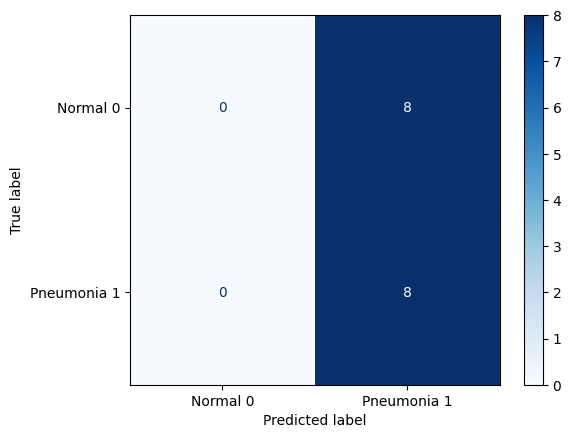

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

layers_model.evaluate(valid_img_final, valid_label_final)

# Calculate and plot the confusion matrix
# Convert predictions to binary labels using a threshold (e.g., 0.5)
y_pred_binary = (layers_model.predict(valid_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(valid_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)

In [36]:
#!pip install lime
#!pip install scikit-image
import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [29]:
img_path = '/content/drive/MyDrive/xray/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'

In [59]:
def proc_img(img_path):
  "process the image"
  img = image.load_img(img_path, target_size=(64, 64))

  # `x` array of shape (64, 64, 3)
  x_img = image.img_to_array(img)

  # We add a dimension to transform our array into a matrix
  # of size (1, 224, 224, 3)
  x_img = np.expand_dims(x_img, axis=0)

  # Finally we preprocess the batch
  # (this does channel-wise color normalization)
  #x_img = preprocess_input(x_img)
  x_img = preprocess_input(x_img)
  return x_img

In [60]:
def predict_fn(images):
  """
  Wrapper function for the model's predict method to handle LIME's input.

  LIME passes a batch of images with shape (num_samples, width, height, channels).
  This function reshapes each image in the batch to match the model's
  expected input shape (num_samples, num_pixels) before prediction.
  """
  # Reshape each image to (num_pixels,)
  reshaped_images = images.reshape(images.shape[0], -1)
  # Make predictions
  predictions = layers_model.predict(reshaped_images)
  return predictions

In [61]:
p_img = proc_img(img_path)

In [62]:
explainer = lime_image.LimeImageExplainer()

In [63]:
# Use predict_fn instead of layers_model.predict directly
explanation = explainer.explain_instance(p_img[0].astype('double'), predict_fn,
                                         top_labels=2, hide_color=0,
                                         num_samples=1000,
                                         distance_metric='cosine')


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

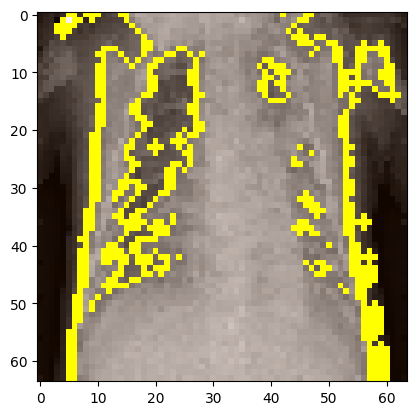

In [64]:
# Get the top labels used in the explanation
top_labels = explanation.top_labels

temp, mask = explanation.get_image_and_mask(label=top_labels[0], positive_only=True,
                                            num_features=15, hide_rest=False,
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));
